# Importación de librerías

In [100]:
import os
import numpy as np
import soundfile as sf
import pywt 
import wavio
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Audio
from scipy import signal
from scipy import stats
from scipy.io import wavfile, loadmat
from scipy.interpolate import interp1d
from PyEMD import EMD, EEMD
from sklearn.model_selection import train_test_split

In [2]:
def hann_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.5 - 0.5*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])


def dwt_decomposition(signal_in, wavelet='db4', mode='periodization',
                      levels='all', return_concatenated=False):
    '''Esta función permite descomponer una señal de entrada en todos los
    posibles niveles de wavelet producto de la aplicación de la "Discrete
    Wavelet Transform" (DWT).
    
    Parámetros
    - signal_in: Señal de entrada
    - wavelet: Wavelet utilizado para el proceso de dwt. Revisar en 
               pywt.families(kind='discrete')
    - mode: Tipo de descomposición en wavelets (revisar wavelets del 
                paquete pywt)
    - levels: Niveles de descomposición para la aplicación de la
                transformada en wavelets.
        - ['all']: Realiza el proceso de disminución a la mitad hasta
                   llegar al final del proceso
        - [(int)#]: Es posible entregar la cantidad de niveles a 
                    descomponer
    - return_concatenated: Booleano que pregunta si es que la salida se
                    entregará concatenada. Al aplicar 'True', se entregará
                    un arreglo con todas las etapas concatenadas. En caso
                    contrario, se entregará una lista donde cada uno de los
                    N + 1 elementos estarán dado por los N coeficientes de
                    detalle, y el último será el/los último/s coeficiente/s 
                    de aproximación
    '''
    # Definición de la señal a descomponer
    to_decompose = signal_in
    
    # Rutina para salida concatenada
    if return_concatenated:
        # Definición del vector wavelet de salida
        wavelet_out = np.array([])
        
        # Para descomposición en todos los niveles posibles
        if levels == 'all':
            while len(to_decompose) > 1:
                # Descomposición de wavelet
                (to_decompose, cD) = pywt.dwt(to_decompose, wavelet=wavelet, 
                                              mode=mode)
                
                # Agregando el detalle al final del vector de salida
                wavelet_out = np.append(cD, wavelet_out)
        
        # Para selección de niveles
        elif isinstance(levels, int):
            # Descomponiendo en niveles
            for _ in range(levels):
                # Descomposición de wavelet
                (to_decompose, cD) = pywt.dwt(to_decompose, wavelet=wavelet, 
                                              mode=mode)

                # Agregando el detalle al final del vector de salida
                wavelet_out = np.append(cD, wavelet_out)

        return np.append(to_decompose, wavelet_out)
        
    # Rutina para salida no concatenada
    else:
        # Definición de la lista de wavelets de salida
        wavelets_out = list()
        
        if levels == 'all':
            while len(to_decompose) > 1:
                # Descomposición de wavelet
                (to_decompose, cD) = pywt.dwt(to_decompose, wavelet=wavelet, 
                                              mode=mode)

                # Agregando el detalle a la lista
                wavelets_out.append(cD)
        
        elif isinstance(levels, int):
            # Descomponiendo en niveles
            for _ in range(levels):
                # Descomposición de wavelet
                (to_decompose, cD) = pywt.dwt(to_decompose, wavelet=wavelet, 
                                              mode=mode)

                # Agregando el detalle al final del vector de salida. Se agregan,
                # considerando que son N niveles de descomposición, de la forma
                # d1, d2, ... , dN 
                wavelets_out.append(cD)

        # Y finalmente se guarda la aproximación
        wavelets_out.append(to_decompose)

        return wavelets_out


def dwt_recomposition(signal_in, wavelet='db4', mode='periodization',
                      levels='all', is_concatenated=False):
    '''Esta función permite recomponer una señal de entrada en todos los
    posibles niveles de wavelet producto de la aplicación de la "Discrete
    Wavelet Transform" (DWT).
    
    Parámetros
    - signal_in: Señal de entrada
    - wavelet: Wavelet utilizado para el proceso de dwt. Revisar en 
               pywt.families(kind='discrete')
    - mode: Tipo de descomposición en wavelets (revisar wavelets del 
                paquete pywt)
    - levels: Niveles de descomposición para la aplicación de la
                transformada en wavelets.
        - ['all']: Realiza el proceso de disminución a la mitad hasta
                   llegar al final del proceso
        - [(int)#]: Es posible entregar la cantidad de niveles a 
                    recomponer
    - is_concatenated: Booleano que pregunta si es que la entrada se
                    entregará concatenada. Al aplicar 'True', se procesará
                    un arreglo con todas las etapas concatenadas. En caso
                    contrario, se entregará una lista donde cada uno de los
                    N + 1 elementos estarán dado por los N coeficientes de
                    detalle, y el último será el/los último/s coeficiente/s 
                    de aproximación
    '''
    # Rutina para entrada concatenada
    if is_concatenated:
        if levels == 'all':
            # Definición de los niveles de reconstrucción
            N = int(np.log2(len(signal_in)))

            # Definición de la señal a recomponer
            cA = np.array([signal_in[0]])

            for i in range(N):
                to_look = 2 ** (i+1)

                # Definición del cD y cA de turno
                cD = signal_in[to_look//2:to_look]
                cA = pywt.idwt(cA, cD, wavelet=wavelet, 
                               mode=mode)

            return cA
    
    else:
        # Definición de los niveles de reconstrucción (el "-1" se debe a
        # que el último elemento es el de aproximación)
        N = len(signal_in) - 1
        
        # Definición de la primera componente de aproximación
        cA = signal_in[-1]
        
        # Iteraciones hasta la recomposición
        for i in reversed(range(N)):
            # Definición del cA de turno (se ajusta el tamaño de
            # cA al tamaño de la señal original ingresada)
            cA = pywt.idwt(cA[:len(signal_in[i])], signal_in[i], 
                           wavelet=wavelet, mode=mode)
            
        return cA


def wavelet_packet_decomposition(signal_in, wavelet='db4', mode='periodization',
                                 levels=3):
    '''Esta función permite descomponer una señal de entrada en todos los
    posibles niveles de wavelet producto de la aplicación de la "Discrete
    Wavelet Transform" (DWT).
    
    Parámetros
    - signal_in: Señal de entrada
    - wavelet: Wavelet utilizado para el proceso de dwt. Revisar en 
               pywt.families(kind='discrete')
    - mode: Tipo de descomposición en wavelets (revisar wavelets del 
                paquete pywt)
    - levels: Número de niveles de descomposición para la aplicación de la
                transformada en wavelets.
                
    Referencias
    (1) S.M. Debbal. Computerized Heart Sounds Analysis. Department of 
        electronic. Faculty of science engineering, University Aboubekr 
        Belkaid. 2011. Algeria.
    '''
    # Definición de la señal a descomponer
    to_decompose = [signal_in]
    
    # Descomponiendo en niveles
    for _ in range(levels):
        # Definición de una lista en las que se almacenarán las 
        # descomposiciones en cada nivel. Nótese que para cada nuevo nivel 
        # se tiene que vaciar para almacenar en orden las descomposiciones 
        wavelets_out = list()
        
        for s_in in to_decompose:
            # Descomposición de wavelet
            (cA, cD) = pywt.dwt(s_in, wavelet=wavelet, mode=mode)

            # Se agregan las señales a lista que mantiene las 
            # descomposiciones ordenadas para cada nivel
            wavelets_out.append(cA)
            wavelets_out.append(cD)
        
        # Una vez terminadas las descomposiciones de cada nivel, se genera
        # este arreglo para aplicar la descomposición de cada uno en el 
        # siguiente nivel
        to_decompose = [i for i in wavelets_out]

    return wavelets_out


def wavelet_packet_recomposition(signal_in, wavelet='db4', mode='periodization'):
    '''Esta función permite recomponer una señal de entrada en todos los
    posibles niveles de wavelet producto de la aplicación de la "Discrete
    Wavelet Transform" (DWT).
    
    Parámetros
    - signal_in: Señal de entrada
    - wavelet: Wavelet utilizado para el proceso de dwt. Revisar en 
               pywt.families(kind='discrete')
    - mode: Tipo de descomposición en wavelets (revisar wavelets del 
                paquete pywt)
    '''
    # Definición de los niveles de reconstrucción
    N = int(np.log2(len(signal_in)))
    
    # Definición de la capa a reconstruir
    layer_to_reconstruct = signal_in

    # Iteraciones hasta la recomposición (por capas)
    for _ in range(N):
        # Definición de una lista en las que se almacenarán las 
        # descomposiciones en cada nivel. Nótese que para cada nuevo nivel 
        # se tiene que vaciar para almacenar en orden las descomposiciones 
        signal_out = list()
        
        # Iteraciones para cada par en cada capa
        for i in range(len(layer_to_reconstruct)// 2):
            # Definición del cA de turno (se ajusta el tamaño de
            # cA al tamaño de la señal original ingresada)
            to_append = pywt.idwt(layer_to_reconstruct[2*i], 
                                  layer_to_reconstruct[2*i+1], 
                                  wavelet=wavelet, mode=mode)
            
            # Se agrega las señales a lista que mantiene las 
            # recomposiciones ordenadas para cada nivel
            signal_out.append(to_append)
        
        # Una vez terminadas las descomposiciones de cada nivel, se genera
        # este arreglo auxiliar para aplicar la descomposición de cada uno  
        # en el siguiente nivel
        layer_to_reconstruct = [i for i in signal_out]
        
    print(len(signal_out))
    return signal_out[0]


def get_wav_of_dwt_level(filename, level_to_get, levels,
                         wavelet='db4', thresholded=True,
                         delta=None, threshold_criteria='hard',
                         threshold_delta='universal',
                         min_percentage=None, print_delta=True):
    '''Creación de sonidos en formato .wav a partir de wavelets de obtenidas
    recuperando el wavelet de un nivel en particular
    
    Parámetros
    - filename: Nombre del archivo a procesar
    - level_to_get: Wavelet del nivel a recuperar
    - levels: Cantidad de niveles en las que se descompondrá la señal
    - wavelet: Wavelet utilizado para el proceso de dwt. Revisar en 
               pywt.families(kind='discrete')
    - delta: Definición de umbral de corte en caso de aplicar thresholding
    - threshold_criteria: Criterio de aplicación de umbral, entre "hard" y "soft"
    - threshold_delta: Selección del criterio de cálculo de umbral. Opciones:
        - ["mad"]: Median Absolute Deviation
        - ["universal"]: universal (4)
        - ["sureshrink"]: Aplicando SURE (4)
        - ["percentage"]: Aplicación del porcentage en relación al máximo
    - min_percentage: Valor del porcentaje con respecto al máximo en la opción
                      "percentage" de la variable "threshold_delta
    - print_delta: Booleano para indicar si se imprime el valor de delta
    '''
    # Cargando señal a procesar
    signal_in, samplerate = sf.read(f'{filename}.wav')
    
    # Probando DWT
    dwt_values = dwt_decomposition(signal_in, wavelet=wavelet, 
                                   mode='periodization',
                                   levels=levels, 
                                   return_concatenated=False)
    
    # Definición de la señal a recuperar según el orden del nivel
    n = level_to_get - 1
    
    if thresholded:
        signal_out = wavelet_thresholding(dwt_values[n], delta=delta, 
                                          threshold_criteria=threshold_criteria,
                                          threshold_delta=threshold_delta,
                                          min_percentage=min_percentage,
                                          print_delta=print_delta)
    else:
        # Señal a obtener
        signal_out = dwt_values[n]
    
    # Samplerate de la señal a recuperar
    sr_out = samplerate // (2 ** level_to_get)
    
    # Generando el archivo de audio
    wavio.write(f"{filename}_DWT_level_{level_to_get}_SR{sr_out}.wav", 
                signal_out, sr_out, sampwidth=3)


def get_wavelet_levels(signal_in, levels_to_decompose=6, levels_to_get='all', wavelet='db4',
                       mode='periodization', threshold_criteria='hard', 
                       threshold_delta='universal', min_percentage=None, 
                       print_delta=False, plot_wavelets=False, plot_show=False,
                       plot_save=(False, None)):
    '''Función que permite obtener señales resulado de una descomposición en niveles
    mediante la dwt (transformada wavelet discreta). Se puede indicar como parámetro
    los niveles de interés para la salida de la función 
    
    Parámetros
    - signal_in: Señal de entrada
    - levels_to_decompose: Cantidad de niveles en las que se descompondrá la señal
    - level_to_get: Wavelet del nivel a recuperar.
        - ['all']: Se recuperan los "levels_to_decompose" niveles
        - [lista]: Se puede ingresar un arreglo de niveles de interés
    - wavelet: Wavelet utilizado para el proceso de dwt. Revisar en 
               pywt.families(kind='discrete')
    - mode: Tipo de descomposición en wavelets (revisar wavelets del 
            paquete pywt)
    - threshold_criteria: Criterio de aplicación de umbral, entre "hard" y "soft"
    - threshold_delta: Selección del criterio de cálculo de umbral. Opciones:
        - ["mad"]: Median Absolute Deviation
        - ["universal"]: universal
        - ["sureshrink"]: Aplicando SURE
        - ["percentage"]: Aplicación del porcentage en relación al máximo
    - min_percentage: Valor del porcentaje con respecto al máximo en la opción
                      "percentage" de la variable "threshold_delta
    - print_delta: Booleano para indicar si se imprime el valor de delta
    - plot_wavelets: Booleano para indicar si se grafican los wavelets
    - plot_show: Booleano para indicar si se muestran estas gráficas
    - plot_save: Tupla que acepta un booleano para indicar si se muestran estas 
                 gráficas (1), y una dirección de almacenamiento en string (2)
    '''
    # Obteniendo la descomposición en wavelets
    dwt_values = dwt_decomposition(signal_in, wavelet=wavelet, mode=mode,
                                   levels=levels_to_decompose, 
                                   return_concatenated=False)
    
    # Definición de la lista de wavelets a retornar
    wavelets_out = []

    if levels_to_get == 'all':
        for interest_signal in dwt_values:
            # Aplicando thresholding
            thresh_signal = wavelet_thresholding(interest_signal, delta=None, 
                                                threshold_criteria=threshold_criteria,
                                                threshold_delta=threshold_delta, 
                                                min_percentage=min_percentage, 
                                                print_delta=print_delta)
            # Agregando a la lista
            wavelets_out.append(thresh_signal)
    else:
        for i in range(len(levels_to_get)):
            # Obtención de la señal a procesar
            interest_signal = dwt_values[levels_to_get[i] - 1]

            # Aplicando thresholding
            thresh_signal = wavelet_thresholding(interest_signal, delta=None, 
                                                threshold_criteria=threshold_criteria,
                                                threshold_delta=threshold_delta, 
                                                min_percentage=min_percentage, 
                                                print_delta=print_delta)
            # Agregando a la lista
            wavelets_out.append(thresh_signal)

    if plot_wavelets:
        plt.figure(figsize=(17,9))
        
        if levels_to_get == 'all':
            gridsize = (len(dwt_values),2)
            
            ax = plt.subplot2grid(gridsize, (0, 0), colspan=2)
            ax.plot(signal_in)
            plt.ylabel('Señal\nOriginal')
            
            # Graficando todos los coeficientes de detalle
            for i in range(len(dwt_values) - 1):
                ax = plt.subplot2grid(gridsize, (i + 1, 0))
                ax.plot(dwt_values[i])
                plt.ylabel(f"Nivel {i + 1}")

                ax = plt.subplot2grid(gridsize, (i + 1, 1))
                ax.plot(wavelets_out[i])
        else:
            gridsize = (len(wavelets_out), 2)
            
            ax = plt.subplot2grid(gridsize, (0, 0), colspan=2)
            ax.plot(signal_in)
            plt.ylabel('Señal\nOriginal')
            
            # Graficando los coeficientes de detalle especificados
            for i in range(len(levels_to_get)):
                ax = plt.subplot2grid(gridsize, (i + 1, 0))
                ax.plot(dwt_values[levels_to_get[i] - 1])
                plt.ylabel(f"Nivel {levels_to_get[i]}")

                ax = plt.subplot2grid(gridsize, (i + 1, 1))
                ax.plot(wavelets_out[i])
        
        plt.suptitle(f'{plot_save[1].split("/")[-1].strip("Wavelets.png")}')
        
        if plot_show:
            # Mostrando la imagen
            plt.show()
            
        if plot_save[0]:
            # Guardando la imagen
            plt.savefig(plot_save[1])

        # Cerrando la figura
        plt.close()
    
    return wavelets_out


def upsample_signal_list(signal_list, samplerate, new_rate, levels_to_get, 
                         N_desired, resample_method='interp1d', stret_method='lowpass',
                         lp_method='fir', fir_method='kaiser', trans_width=50, gpass=1, 
                         gstop=80, plot_filter=False, plot_signals=False,
                         plot_wavelets=True, normalize=True):
    '''Función que permite upsamplear una lista de señales a una tasa de muestreo
    determinada (new_rate) desde una tasa de muestreo dada (samplerate).
    
    Parámetros
    - signal_list: Lista de señales a sobremuestrear
    - samplerate: Tasa de muestreo de las señales a sobremuestrear (señales de entrada)
    - new_rate: Nueva tasa de muestreo de las señales (señales de salida)
    - levels_to_get: Niveels de los Wavelet a recuperar
        - ['all']: Se recuperan los "levels_to_decompose" niveles
        - [lista]: Se puede ingresar un arreglo de niveles de interés
    - N_desired: Cantidad de niveles en las que se descompondrá la señal
    - method: Método de submuestreo
        - ['lowpass']: Se aplica un filtro pasabajos para evitar
                     aliasing de la señal. Luego se submuestrea
        - ['cut']: Simplemente se corta en la frecuencia de interés
        - ['resample']:Se aplica la función resample de scipy
        - ['resample_poly']:Se aplica la función resample_poly de scipy
    - trans_width: Banda de transición entre la frecuencia de corte de
                   la señal original (que representa la frecuencia de 
                   corte del rechaza banda) y la pasa banda del filtro
                   aplicado para eliminar las repeticiones [1]
    - lp_method: Método de filtrado para elección lowpass
        - ['fir']: se implementa un filtro FIR
        - ['iir']: se implementa un filtro IIR
    - fir_method: Método de construcción del filtro FIR  en caso 
                  de seleccionar el método lowpass con filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano para activar ploteo del filtro aplicado
    - plot_signals: Booleano para activar ploteo de la magnitud de las señales
    - plot_wavelets: Booleano para activar ploteo de los wavelets obtenidos a 
                     partir del proceso
    - normalize: Normalización de la señal de salida
    '''
    
    # Definición de la lista donde se almacenarán los wavelets
    upsampled_signals = []

    for i in range(len(signal_list)):
        # Aplicando un upsampling
        resampled_signal = upsampling_signal(signal_list[i], 
                                             samplerate / (2 ** (levels_to_get[i])), 
                                             new_rate, N_desired=N_desired, 
                                             resample_method=resample_method,
                                             stret_method=stret_method, lp_method=lp_method, 
                                             fir_method=fir_method, trans_width=trans_width,
                                             gpass=gpass, gstop=gstop, 
                                             correct_by_gd=True, gd_padding='periodic',
                                             plot_filter=False, plot_signals=plot_signals,
                                             normalize=normalize)

        # Guardando
        upsampled_signals.append(resampled_signal)
    
    if plot_wavelets:
        # Creando el plot de grillas
        gridsize = (len(signal_list), 2)
        plt.figure(figsize=(9, 6))
        
        # Graficando los componentes a la izquierda
        for i in range(len(signal_list)):
            ax = plt.subplot2grid(gridsize, (i, 0))
            ax.plot(upsampled_signals[i])
        
        # Y graficando la suma a la derecha
        ax = plt.subplot2grid(gridsize, (0, 1), colspan=1, 
                              rowspan=len(signal_list))
        
        # Suma de wavelets
        wavelet_final = sum(upsampled_signals)
        ax.plot(wavelet_final)
        plt.show()
        plt.close()
    
    return upsampled_signals


def zeropadding_to_pot2(signal_in):
    '''Se busca saber entre qué potencias de 2 se encuentra se encuentra el largo del arreglo,
    el cual está dado por aplicar el logaritmo base 2 al largo de la señal. Con esto, se 
    obtiene la cantidad de 'potencias de 2' que hay que aplicar al largo para obtenerlo.
    Se toma este número, y se obtiene la parte entera de él.
    
    Esta función busca rellenar con ceros hasta que el largo de la señal sea una potencia de 2.
    
    Parámetros
    - signal_in: Señal a rellenar con ceros'''
    # Pasar la señal a arreglo de numpy
    signal_in = np.array(signal_in)
    
    # Potencia de 2 por lo bajo del largo de la señal
    n2_pot = int(np.log2(len(signal_in)))
    
    # Luego, la cantidad de ceros que hay que agregar a la señal para 
    # que sea tenga como largo una potencia de 2 corresponde a 
    # 2 ** (n2_pot+1) - largo_de_señal
    n = n2_pot + 1
    
    return np.append(signal_in, [0] * (2**n - len(signal_in)))

                     
def upsampling_signal(signal_in, samplerate, new_samplerate,
                      N_desired=None, resample_method='interp1d',
                      stret_method='lowpass', lp_method='fir', 
                      fir_method='kaiser', trans_width=50, gpass=1, gstop=80, 
                      correct_by_gd=True, gd_padding='periodic',
                      plot_filter=False, plot_signals=False,
                      normalize=True):
    '''Función que permite aumentar la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la nueva tasa
    de muestreo deseada.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    new_samplerate : int
        Tasa de muestreo deseada de la señal.
    N_desired : int or NoneType, optional
        Cantidad de puntos deseadas en la señal de salida. Por defecto es None.
    resample_method : {'resample', 'resample poly', 'interp1d', 'stretching'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'stretching' se realiza el 
        estiramiento a la señal por un parámetro "N_st" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    stret_method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    lp_method : {'fir', 'iir'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Por defecto es 'fir'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    trans_width : int 
        Banda de transición entre la frecuencia de corte de la señal original (que representa 
        la frecuencia de corte del rechaza banda) y la pasa banda del filtro aplicado para 
        eliminar las repeticiones [1].
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    plot_signals : bool
        Activar ploteo de la magnitud de las señales.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula la cantidad de puntos a añadir en stretch
    N_st = int(new_samplerate / samplerate)
    
    if resample_method == 'stretching':
        # Aplicando stretching
        signal_stretched = stretch_signal(signal_in, N_stretch=N_st)

        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            if len(signal_stretched) < N_desired: 
                signal_stretched = np.append(signal_stretched,
                                             [0] * (N_desired \
                                                    - len(signal_stretched)))
            else:
                signal_stretched = signal_stretched[:N_desired]


        if stret_method == 'lowpass':
            # Definición de las bandas del filtro
            freq_stop = samplerate / 2
            freq_pass = freq_stop - trans_width

            # Aplicando el filtro
            _, signal_out = lowpass_filter(signal_stretched, new_samplerate, 
                                           freq_pass, freq_stop, method=lp_method, 
                                           fir_method=fir_method, gpass=gpass, 
                                           gstop=gstop, correct_by_gd=correct_by_gd,
                                           gd_padding=gd_padding,
                                           plot_filter=plot_filter, 
                                           normalize=normalize)    
        elif stret_method == 'cut':
            # Definición de la frecuencia de corte
            freq_stop = samplerate / 2
            # Método de corte
            signal_out = lowpass_cut_frequency(signal_stretched, samplerate, 
                                               freq_stop, signal_ref=signal_in)
        
    elif resample_method == 'resample':
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / samplerate * new_samplerate)
        
        signal_out = signal.resample(signal_in, N_out)
    
    elif resample_method == 'resample_poly':
        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / samplerate * new_samplerate)
        
        # Señal resampleada
        signal_out = signal.resample_poly(signal_in, N_out, len(signal_in))
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_in))
        
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / samplerate * new_samplerate)
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_in) - 1, N_out)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_in)
        
        # Definición de la señal de salida
        signal_out = f(x_new)
    
    if plot_signals:
        plt.subplot(3,1,1)
        plt.plot(abs(np.fft.fft(signal_in)))
        plt.title('Magnitud señal de entrada')

        plt.subplot(3,1,2)
        plt.plot(abs(np.fft.fft(signal_stretched)))
        plt.title('Magnitud señal stretched')

        plt.subplot(3,1,3)
        plt.plot(abs(np.fft.fft(signal_out)))
        plt.title('Magnitud señal salida')

        plt.show()
    
    if normalize:
        return signal_out / max(abs(signal_out))
    else:
        return signal_out

                     
def thresholding_processing(signal_in):
    '''Proceso que permite separar las envolventes de los murmullos del primer
    sonido cardíaco (S1) que no fueron totalmente removidos por ALPF
    
    Referencias: 
    - Qingshu Liu, et.al. An automatic segmentation method for heart sounds.
      2018. Biomedical Engineering.
    '''
    
    # Definición de los parámetros según el paper
    lamb = 0.8
    theta_c = 0.025
    
    # Definición del factor dependiente de la naturaleza de la señal
    theta_a = lamb * np.std(signal_in)
    
    # Definición del umbral de corte
    theta = min(theta_a, theta_c)
    
    return np.array([i if abs(i) >= theta else 0 for i in signal_in])


def downsampling_signal(signal_in, samplerate, freq_pass, freq_stop, 
                        method='lowpass', lp_method='fir',
                        resample_method='interp1d',
                        fir_method='kaiser', gpass=1, gstop=80,
                        correct_by_gd=True, gd_padding='periodic',
                        plot_filter=False, normalize=True):
    '''Función que permite disminuir la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la frecuencia
    de corte para el pasabajo. Es decir, dada una frecuencia de corte
    de interés, se resampleará la señal al doble de esa frecuencia.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    freq_stop : float
        Frecuencia de corte de la rechaza banda. Esta es la que se toma
        en cuenta al momento de hacer el último corte (por ende, si 
        busca samplear a 2kHz, seleccione este parámetro en 1kHz).
    method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    lp_method : {'fir', 'iir', 'cut'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. 'cut' es un método no convencional en el que
        se todas las frecuencias filtradas de la magnitud se hacen 0. Por defecto es 'fir'.
    resample_method : {'resample', 'resample poly', 'interp1d', 'decimation'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'decimation' se  realiza una 
        decimación a la señal por un parámetro "N_dec" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    -----------
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula el paso de la decimación
    N_dec = round(samplerate / (freq_stop * 2))
    
    # Calculo de la nueva tasa de muestreo
    new_rate = 2 * freq_stop
    
    # Selección del método del pasabajos
    if method == 'lowpass':
        # Aplicando el filtro pasa bajos
        _, signal_lp = lowpass_filter(signal_in, samplerate, freq_pass, 
                                      freq_stop, method=lp_method, 
                                      fir_method=fir_method, gpass=gpass, 
                                      gstop=gstop, plot_filter=plot_filter,
                                      correct_by_gd=correct_by_gd,
                                      gd_padding=gd_padding,
                                      normalize=normalize)
    elif method == 'cut':
        signal_lp = lowpass_cut_frequency(signal_in, samplerate, 
                                          freq_stop)
    else:
        raise Exception('Opción de método no válido. Por favor, ingrese'
                        ' un valor válido.')
    
    # Selección del método de resampleo
    if resample_method == 'resample':
        return new_rate, signal.resample(signal_lp, 
                                         len(signal_lp)//N_dec)
    
    elif resample_method == 'resample_poly':
        return new_rate, signal.resample_poly(signal_lp, 
                                              len(signal_lp)//N_dec, 1)
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_lp))
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_lp) - 1, len(signal_lp)//N_dec)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_lp)

        return new_rate, f(x_new)
    
    elif resample_method == 'decimation':
        # Calculo de la nueva tasa de muestreo
        new_rate = samplerate // N_dec
        
        return new_rate, decimation_signal(signal_lp, N_decimate=N_dec)

                     
def lowpass_filter(signal_in, samplerate, freq_pass, freq_stop,
                   method='fir', fir_method='kaiser', gpass=1, 
                   gstop=80, plot_filter=False, correct_by_gd=True,
                   gd_padding='periodic', normalize=True):
    '''Función que permite crear un filtro pasabajos con una frecuencia
    de corte ingresada por el usuario el cual se aplicará a la señal de
    entrada de la función.
    
    Parámetros
    - signal: Señal a filtrar
    - samplerate: Tasa de muestreo de la señal utilizada
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda
    - cutoff_freq: Frecuencia de corte en radianes (pi representa fs/2)
    - method: Método de filtrado
        - ['fir']: Se implementa mediante un filtro fir
        - ['iir']: Se implementa mediante un filtro iir
        - ['cut']: Se implementa simplemente cortando en la frecuencia de interés
    - fir_method: Método de construcción del filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano que permite graficar la señal a ifiltrar y el filtro
    - correct_by_gd: Booleano que permite corregir la salida del filtro FIR por su
                     retraso de grupo
    - gd_padding: Formato para el padding de la señal de entrada
        - [None]: No se hace padding
        - ['zero']: Se hace padding con "len(signal_in)" ceros a la izquierda y
                    derecha de la señal
        - ['periodic']: Se hace padding copiando la señal 3 veces
        - ['constant']: Se hace padding copiando el primer y el último valor para
                        el caso de la izquierda y la derecha respectivamente
    - normalize: Normalización de la señal de salida
    '''
    # Obtención de los parámetros para cada método
    if method == 'fir':
        num = fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=gpass,
                                 gstop=gstop, use_exact=True, method=fir_method,
                                 print_window=plot_filter, apply_firwin=False)
        den = 1
        
        # Definición gd
        _, gd_list = signal.group_delay((num, den))
        
        gd = round(np.mean(gd_list))
        
        
    elif method == 'iir':
        num, den = signal.iirdesign(wp=freq_pass / (samplerate/2),
                                    ws=freq_stop / (samplerate/2),
                                    gpass=gpass, gstop=gstop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
        
        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False
        
        # Definición gd (ya que su fase no es lineal)
        gd = None
        
    elif method == 'cut':
        signal_filtered =  lowpass_cut_frequency(signal_in, samplerate, 
                                                 freq_stop)
        
        # Se define no plotear dado que no hay filtro (independiente de la entrada)
        plot_filter = False
        
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
        
        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False
        
        # Definición gd (ya solo hay corte, no desfase)
        gd = 0
        
        # Definición de salida num y den
        num = den = None
    
    # Opción corregir por delay de grupo (solo para FIR)
    if correct_by_gd:
        signal_to_filt, signal_filtered =\
            filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den)
    else:
        if method != 'cut':
            # Definición de la señal a filtrar
            signal_to_filt = signal_in
            
            # Filtrando
            signal_filtered = signal.lfilter(num, den, signal_to_filt)
    
    if plot_filter:        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots(2,1)
        
        # Graficando la señal
        ax[0].set_title('Señal a filtrar')
        ax[0].plot(signal_to_filt)
        
        # Y obteniendo la función de transferencia h
        w, h = signal.freqz(num, den)
        # Graficando el filtro
        ax[1].set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax[1].plot(w, magnitude, 'r')
        ax[1].set_ylabel('Magnitude [dB]', color='r')
        ax[1].set_xlabel('Frequencia [rad/sample]')
        ax[1].set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax[1].twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return (gd, num, den), signal_filtered / max(abs(signal_filtered))
    else:
        return (gd, num, den), signal_filtered

                     
def highpass_filter(signal_in, samplerate, freq_stop, freq_pass,
                    method='fir', lp_process='manual_time_design',
                    fir_method='kaiser', gpass=1, gstop=80, 
                    plot_filter=False, correct_by_gd=True,
                    gd_padding='periodic', normalize=True):
    '''Función que permite crear un filtro pasa altos con una frecuencia
    de corte ingresada por el usuario el cual se aplicará a la señal de
    entrada de la función.
    
    Parameters
    ----------
    signal_in: list or ndarray 
        Señal a filtrar.
    samplerate: int
        Tasa de muestreo de la señal utilizada.
    freq_stop : float
        Frecuencia de corte de la rechaza banda.
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    method : {'fir', 'iir', 'cut'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Para 'cut' simplemente se hacen cero todas
        las frecuencias de la rechaza banda. Por defecto es 'fir'.
    lp_process : {'manual_freq_design', 'manual_time_design', 'freqz_design', 
                  'signal_substraction'}, optional
        Alternativa de construcción de filtro pasa altos. 'manual_freq_design' lo diseña a 
        partir del espectro, 'manual_time_design' a partir de su respuesta al impulso, 
        'freqz_design' de los coeficientes num y den, y 'signal_substraction' hace una resta
        entre la señal original y la filtrada pasabajos. No se recomienda este último. 
        Por defecto es 'manual_time_design'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de aplicación del filtro FIR. 'window'es construcción por método de la ventana,
        'kaiser' es construcción por método de ventana kaiser y 'remez' es construcción por 
        algoritmo remez. Por defecto es 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    plot_filter : bool, optional
        Activar ploteo del filtro aplicado. Por defecto es False.
    correct_by_gd : bool, optional 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Returns
    -------
    info : tuple
        Contiene delay de grupo, numerador y denominador del polinomio que describe el filtro
    signal_filtered : ndarray
        Señal filtrada.
    
    Referencias
    -----------
    [1] https://dsp.stackexchange.com/questions/20171/
        how-to-produce-a-high-pass-filter-from-a-low-pass-one
    '''
    
    if method == 'fir':
        num = fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=gpass,
                                 gstop=gstop, use_exact=True, method=fir_method,
                                 fir_type='highpass', print_window=plot_filter,
                                 apply_firwin=True)
        den = 1
        
        # Definición gd
        _, gd_list = signal.group_delay((num, den))
        
        gd = round(np.mean(gd_list))
            
    elif method == 'iir':
        num, den = signal.iirdesign(wp=freq_pass / (samplerate/2),
                                    ws=freq_stop / (samplerate/2),
                                    gpass=gpass, gstop=gstop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
        
        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False
        
        # Definición gd (ya que su fase no es lineal)
        gd = None
    
    elif method == 'cut':
        # Filtrando la señal
        signal_filtered =  highpass_cut_frequency(signal_in, samplerate, 
                                                  freq_stop)
        
        # Se define no plotear dado que no hay filtro (independiente de la entrada)
        plot_filter = False

        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None

        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False

        # Definición gd (ya solo hay corte, no desfase)
        gd = 0

        # Definición de salida num y den
        num = den = None
        
    elif method == 'lowpass_complement':
        return highpass_by_complement_lowpass_filter(signal_in, samplerate, 
                                                     freq_stop, freq_pass,
                                                     lp_process=lp_process, 
                                                     fir_method=fir_method, 
                                                     gpass=gpass, gstop=gstop, 
                                                     plot_filter=plot_filter, 
                                                     correct_by_gd=correct_by_gd, 
                                                     gd_padding=gd_padding, 
                                                     normalize=normalize)
    else:
        raise Exception('Opción de método no válido. Por favor, ingrese'
                        ' una opción disponible válido.')
    
    # Opción corregir por delay de grupo (solo para FIR)
    if correct_by_gd:
        signal_to_filt, signal_filtered =\
            filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den)
    else:
        if method != 'cut':
            # Definición de la señal a filtrar
            signal_to_filt = signal_in
            
            # Filtrando
            signal_filtered = signal.lfilter(num, den, signal_to_filt)
    
    if plot_filter:        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots(2,1)
        
        # Graficando la señal
        ax[0].set_title('')
        ax[0].plot(signal_to_filt)
        
        # Y obteniendo la función de transferencia h
        w, h = signal.freqz(num, den, worN=2048)
        # Graficando el filtro
        ax[1].set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax[1].plot(w, magnitude, 'r')
        ax[1].set_ylabel('Magnitude [dB]', color='r')
        ax[1].set_xlabel('Frequencia [rad/sample]')
        ax[1].set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax[1].twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return (gd, num, den), signal_filtered / max(abs(signal_filtered))
    else:
        return (gd, num, den), signal_filtered

                     
def bandpass_filter(signal_in, samplerate, freq_stop_1, freq_pass_1, 
                    freq_pass_2, freq_stop_2, bp_method='sequence', 
                    lp_method='fir', hp_method='fir', 
                    lp_process='manual_time_design',
                    fir_method='kaiser', gpass=1, gstop=80, 
                    plot_filter=False, correct_by_gd=True, 
                    gd_padding='periodic', normalize=False):
    '''Función que permite crear un filtro pasa banda con frecuencias
    de corte ingresadas por el usuario el cual se aplicará a la señal de
    entrada de la función.
    
    Parameters
    ----------
    signal_in: list or ndarray 
        Señal a filtrar.
    samplerate: int
        Tasa de muestreo de la señal utilizada.
    freq_stop_1 : float
        Frecuencia de corte de la rechaza banda por la izquierda.
    freq_pass_1 : float
        Frecuencia de corte de la pasa banda por la izquierda.
    freq_pass_2 : float
        Frecuencia de corte de la pasa banda por la derecha.
    freq_stop_2 : float
        Frecuencia de corte de la rechaza banda por la derecha.
    bp_method : {'sequence', 'scipy_fir', 'scipy_iir'}, optional
        Método de construcción del filtro pasa banda. Para 'sequence' se concatena un
        filtro pasa bajos seguido de un pasa altos (es la única opción que soporta
        corrección por GD). Para 'scipy_fir' y 'scipy_iir' se hace uso de las funciones
        'firwin' y 'iirdesign' para el diseño del filtro (ajustado a los parámetros
        solicitados). Por defecto es 'sequence'.
    lp_method : {'fir', 'iir', 'cut'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Para 'cut' simplemente se hacen cero todas
        las frecuencias de la rechaza banda. Por defecto es 'fir'.
    lp_process : {'manual_freq_design', 'manual_time_design', 'freqz_design', 
                  'signal_substraction'}, optional
        Alternativa de construcción de filtro pasa altos. 'manual_freq_design' lo diseña a 
        partir del espectro, 'manual_time_design' a partir de su respuesta al impulso, 
        'freqz_design' de los coeficientes num y den, y 'signal_substraction' hace una resta
        entre la señal original y la filtrada pasabajos. No se recomienda este último. 
        Por defecto es 'manual_time_design'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de aplicación del filtro FIR. 'window'es construcción por método de la ventana,
        'kaiser' es construcción por método de ventana kaiser y 'remez' es construcción por 
        algoritmo remez. Por defecto es 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    plot_filter : bool, optional
        Activar ploteo del filtro aplicado. Por defecto es False.
    correct_by_gd : bool, optional 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Returns
    -------
    signal_filtered : ndarray
        Señal filtrada.
    '''
    # Normalizando la señal de entrada (en caso de no estar normalizada)
    signal_norm = signal_in / max(abs(signal_in))
    
    if bp_method == 'sequence':
        # En primer lugar se aplica un filtro pasabajo (frecuencias más altas)
        info_lp, signal_lp = lowpass_filter(signal_norm, samplerate, 
                                            freq_pass=freq_pass_2, 
                                            freq_stop=freq_stop_2,
                                            method=lp_method, 
                                            fir_method=fir_method, 
                                            gpass=gpass, gstop=gstop, 
                                            plot_filter=False, 
                                            correct_by_gd=correct_by_gd, 
                                            gd_padding=gd_padding, 
                                            normalize=False)
        
        # Luego se aplica un filtro pasa altos (frecuencias más bajas)
        info_hp, signal_bp = highpass_filter(signal_lp, samplerate, 
                                             freq_stop=freq_stop_1, 
                                             freq_pass=freq_pass_1,
                                             method=hp_method,
                                             lp_process=lp_process,
                                             fir_method=fir_method, 
                                             gpass=gpass, gstop=gstop, 
                                             plot_filter=False, 
                                             correct_by_gd=correct_by_gd, 
                                             gd_padding=gd_padding, 
                                             normalize=normalize)
        
    else:
        if bp_method == 'scipy_fir':
            # Obteniendo los filtros correspondientes
            lp_wind = fir_filter_adapted(freq_pass=freq_pass_2, 
                                         freq_stop=freq_stop_2, 
                                         samplerate=samplerate, gpass=gpass,
                                         gstop=gstop, use_exact=True, print_window=False,
                                         fir_type='lowpass', method='kaiser', parity='odd', 
                                         apply_firwin=False)
            
            hp_wind = fir_filter_adapted(freq_pass=freq_stop_1, 
                                         freq_stop=freq_pass_1, 
                                         samplerate=samplerate, gpass=gpass,
                                         gstop=gstop, use_exact=True, print_window=False,
                                         fir_type='highpass', method='kaiser', parity='odd', 
                                         apply_firwin=True)
            
            # Definición del largo de la ventana (se escoge el máximo para que cumpla ambas
            # condiciones ya que en caso de elegir la menor no se cumpliría la otra)
            N = max(len(lp_wind), len(hp_wind))
            
            # Definición de la banda de transición
            width = min(abs(freq_pass_1 - freq_stop_1), abs(freq_pass_2 - freq_stop_2))
            
            # Aplicando firwin
            h = signal.firwin(N, [1/2 * (freq_pass_1 + freq_stop_1), 1/2 * (freq_pass_2 + freq_stop_2)],
                              width=width, window='blackman', pass_zero='bandpass', fs=samplerate)
            
            # Definiendo entonces numerador y denominador
            num = h
            den = 1
            
            # Definición gd
            _, gd_list = signal.group_delay((num, den))
            
            # Definición de gd
            gd = round(np.mean(gd_list))
            
        elif bp_method == 'scipy_iir':
            # Diseñando el filtro pasa banda
            num, den = signal.iirdesign(wp=[freq_pass_1, freq_pass_2],
                                        ws=[freq_stop_1, freq_stop_2],
                                        gpass=gpass, gstop=gstop,
                                        fs=samplerate)
            
            # Definiendo de manera automática correct_by_gd en False (solo para FIR)
            correct_by_gd = False
        
        # Opción corregir por delay de grupo (solo para FIR)
        if correct_by_gd:
            _, signal_bp =\
                filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den)
        else:
            if bp_method != 'cut':
                # Filtrando
                signal_bp = signal.lfilter(num, den, signal_in)
    
    if plot_filter:
        if bp_method == 'sequence':
            # Es necesario obtener ambas funciones de transferencia
            w, h_low = signal.freqz(b=info_lp[1], a=info_lp[2], worN=1024, fs=samplerate)
            w, h_high = signal.freqz(b=info_hp[1], a=info_hp[2], worN=1024, fs=samplerate)

            # Luego, la función de transferencia es la multiplicación entre ambas
            h_band = h_low * h_high
        
        else:
            w, h_band = signal.freqz(b=num, a=den, worN=1024, fs=samplerate)
        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots()
        
        magnitude = 20 * np.log10(abs(h_band))
        ax.plot(w, magnitude, 'r')
        ax.set_ylabel('Magnitude [dB]', color='r')
        ax.set_xlabel('Frequencia [rad/sample]')
        ax.set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax.twinx()
        angles = np.unwrap(np.angle(h_band))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return signal_bp / max(abs(signal_bp))
    else:
        return signal_bp
                     

def fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=1,
                       gstop=80, use_exact=True, print_window=True,
                       fir_type='lowpass', method='window', parity='odd', 
                       apply_firwin=False):
    '''Diseño de filtros FIR mediante el método de ventaneo. Esta 
    función retorna los coeficientes h[n] del filtro en el tiempo.
    Este filtro minimiza el orden del filtro seleccionando la 
    ventana más conveniente en base a la declaración en decibeles
    de la ganancia de la rechaza banda.
    
    Parameters
    ----------
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    freq_stop : float
        Frecuencia de corte de la rechaza banda.
    samplerate: int 
        Tasa de muestreo de la señal utilizada.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    use_exact : bool, optional
        Booleano que indica si se usa el valor exacto de transición entre bandas 
        (delta omega). Por defecto es True
    print_window : bool, optional.
        Si se imprime la ventana seleccionada y su orden. Por defecto es False.
    fir_type : {'lowpass', 'highpass'}, optional
        Filtro FIR a crear, que puede ser pasa bajo o pasa alto. Por defecto es 'lowpass'.
    method : {'window', 'kaiser', 'remez'}, optional
        Método de aplicación del filtro FIR. 'window'es construcción por método de la ventana,
        'kaiser' es construcción por método de ventana kaiser y 'remez' es construcción por 
        algoritmo remez. Por defecto es 'kaiser'.
    parity : {'odd', 'even'}, optional
        Cantidad par o impar de puntos para el filtro. Por defecto es 'odd'.
    apply_firwin : bool, optional
        Si se aplica la función firwin o si se hace manualmente. Por defecto es False.
    
    Returns
    -------
    h_n : ndarray
        Ventana del filtro deseado.
    
    Referencias:
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    [2] Página CCRMA de Julius O. Smith III, disponible en:
        https://ccrma.stanford.edu/~jos/
    '''
    # Definición de los ripples en escala absoluta [1]
    delta_p = (10**(gpass/20) - 1)/(10**(gpass/20) + 1)
    delta_s = (1 + delta_p)/(10**(gstop/20))
    # Se escoge el mínimo delta para el diseño de la
    # ganancia A [1]
    delta = min(delta_p, delta_s)
    
    # Definición de ganancia límite
    A = -20*np.log10(delta) 
    
    # Definición de la frecuencia de corte
    cutoff_freq = (freq_pass + freq_stop) / 2
    # Definición de la frecuencia central angular
    omega_c = 2 * np.pi * cutoff_freq / samplerate
    
    # Definición del ancho de banda delta omega 
    trans_width = abs(freq_pass - freq_stop)
    # Definición del ancho de banda delta omega angular
    band_w = 2 * np.pi * trans_width / samplerate
    
    # Para el procedimiento del filtro FIR mediante ventaneo
    if method == 'window':
        # Definición de las ventanas
        windows = (('rectangular', 21, 4 * np.pi, 1.8 * np.pi),
                   ('bartlett', 26, 8 * np.pi, 6.1 * np.pi),
                   ('hann', 44, 8 * np.pi, 6.2 * np.pi),
                   ('hamming', 53, 8 * np.pi, 6.6 * np.pi),
                   ('blackman', 71, 12 * np.pi, 11 * np.pi))

        # Selección de la ventana
        index_window = np.argmin([abs(i[1] - A) for i in windows])

        # Definición de la ventana elegida
        window_choose = windows[index_window][0]
        
        # Una vez seleccionada la ventana, se escoge el orden del filtro,
        # procurando que el ancho del lóbulo principal no sea más grande
        # que la frecuencia de corte [1][2]
        delta_w = 3 if use_exact else 2
        L = round(windows[index_window][delta_w] / band_w)

        # Definición del orden del polinomio de la función de trans-
        # ferencia (largo del filtro). Mientras que L es el largo de
        # la respuesta al impulso
        M = L - 1
        
    # Para el procedimiento mediante ventana kaiser
    elif method == 'kaiser':
        # Definición de la ventana elegida
        window_choose = 'kaiser' 
        
        # Cálculo del beta
        beta = beta_kaiser(A)
        
        # Estimación del orden del filtro [1]
        M = int(np.ceil((A - 8) / (2.285 * band_w)))
    
    # Para el procedimiento mediante algoritmo remez
    elif method == 'remez':
        # El orden del filtro está dado por la relación empírica 
        # propuesta por Kaiser
        M = (-20*np.log10(np.sqrt(delta_s*delta_p)) - 13)/(2.324*band_w)
        # Definición del parámetro de construcción de la ventana
        K = delta_p/delta_s
        
        # Especificación del filtro
        M = int(np.ceil(M))
        M = M  if M % 2 == 0 else M + 1
        
        # Se define el set de frecuencias crítico para el algotitmo
        # el cual contiene [0, wp, ws, pi], donde todas son divididas
        # en 2*pi (se expresan en "f").
        fo = [0, freq_pass, freq_stop, samplerate/2]
        
        # Este vector contiene los valores que tomarán las amplitudes de
        # las frecuencias de interés definidas anteriormente (cada una 
        # representa un rango, por ejemplo entre 0 y freq_pass -> 1  
        # y entre  freq_stop y samplerate/2 -> 0)
        ao = [1, 0]
        
        # Corresponde a los valores que toma la función W(omega) para 
        # cada banda
        W = [1, K]
        
        # Aplicando entonces Parks-McClellan
        return signal.remez(M + 1, fo, ao, W, fs=samplerate)
    
    # OJO: La opción paridad tiene directa relación con el largo de la 
    # salida L, no con M. Por ende, para 'odd', se hará M par para que
    # L sea impar (y viceversa, ya que L = M + 1).
    if parity == 'odd':
        # Si es que M es par, mantenerlo par, si es que es impar, 
        # sumar 1 (esto para L, no para M)
        M = M if M % 2 == 0 else M + 1
    
    elif parity == 'even':
        # Si es que M es impar, mantenerlo impar, si es que es par, 
        # sumar 1 (esto para L, no para M)
        M = M if M % 2 != 0 else M + 1
    
    else:
        raise Exception('Opción de paridad no válida.')
    
    # Redefiniendo L
    L = M + 1
    
    if print_window:
        print(f'Ventana: {window_choose}\n'
              f'Largo resp. al impulso: {L}')
    
    # Aplicando el filtro
    if apply_firwin:
        if window_choose == 'kaiser':
            window_choose = ('kaiser', beta)
            
        return signal.firwin(L, cutoff_freq, 
                             window=window_choose,
                             pass_zero=fir_type,
                             fs=samplerate)
    else:
        # Selección de ventana
        if window_choose == 'rectangular':
            window = np.ones(L)
        elif window_choose == 'bartlett':
            window = np.bartlett(L)
        elif window_choose == 'hann':
            window = np.hanning(L)
        elif window_choose == 'hamming':
            window = np.hamming(L)
        elif window_choose == 'blackman':
            window = np.blackman(L)
        elif window_choose == 'kaiser':
            window = np.kaiser(L, beta)
        
        # Definición de la respuesta al impulso del filtro pasabajo 
        # ideal
        hd = lambda n: (np.sin(omega_c*(n - M/2))/(np.pi*(n - M/2)))\
                        if (n != M/2) else omega_c/np.pi
        
        # Calculando
        hd_n = np.asarray([hd(i) for i in range(L)])
        return  hd_n * window

                     
def beta_kaiser(A):
    '''Función por tramos que indica el valor que debe tomar el
    parámetro beta
    
    Parámetros
    - A: Ganancia máxima entre ripple de pasa banda y rechaza 
         banda obtenido anteriormente mediante la parametrización
         
    Referencias
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    '''
    if A < 21:
        return 0
    elif 21 <= A <= 50:
        return 0.5842 * (A - 21) ** 0.4 + 0.07886 * (A - 21)
    else:
        return 0.1102 * (A - 8.7)

                     
def filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den):
    '''Función que permite realizar el proceso de filtrado y de corrección por
    delay de grupo a una señal a filtrar.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal a filtrar y corregir.
    gd : int or float
        Delay de grupo de la señal.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    num : int, float, list or ndarray
        Coeficientes del numerador para el filtro.
    den : int, float, list or ndarray
        Coeficientes del denominador para el filtro.
    
    Returns
    -------
    signal_to_filt : ndarray
        Señal que se utiliza para filtrar considerando el gd_padding.
    signal_filtered : ndarray
        Señal filtrada y corregida por el delay de grupo.
    '''
    # Presentación de la señal de entrada
    if gd_padding is None:
        signal_to_filt = signal_in

    elif gd_padding == 'zero':
        signal_to_filt = np.concatenate(([0] * len(signal_in),
                                         signal_in,
                                         [0] * len(signal_in)))
    elif gd_padding == 'periodic':
        signal_to_filt = np.concatenate((signal_in,
                                         signal_in,
                                         signal_in))
    elif gd_padding == 'constant':
        signal_to_filt = np.concatenate(([signal_in[0]] * len(signal_in),
                                         signal_in,
                                         [signal_in[-1]] * len(signal_in)))
    else:
        raise Exception('Opción de padding no disponible. Por favor, intente '
                        'nuevamente')

    # Para poder filtrar el audio
    signal_filtered = signal.lfilter(num, den, signal_to_filt)

    # Si se hace padding, se debe cortar de tal forma que se logre sincro-
    # nizar la señal de entrada en función del delay de grupo
    if gd_padding is not None:
        delay = gd
        
        # Definición de los índices a considerar. Se escogen estos índices
        # ya que se asume que el comportamiento ideal de la señal 3 veces
        # paddeada, se encuentra en el centro del arreglo
        ini_index = int(len(signal_in) + delay)
        end_index = int(2 * len(signal_in) + delay)

        # Recortando
        signal_filtered = signal_filtered[ini_index:end_index]

    return signal_to_filt, signal_filtered


def variance_fractal_dimension_OLD(signal_in, samplerate, NT=1024, noverlap=512, 
                               nk=4, step_size_method='unit'):
    '''Variance fractal dimension está dada por la expresión:
    D_o = D_E + 1 - H

    Donde D_E corresponde a la dimensión del problema a resolver (por
    ejemplo, en el caso de una curva D_E = 1, para un plano D_E = 2 y 
    para el espacio D_E = 3) y donde:
        H = lim_{dt -> 0} log(var(ds))/(2*log(dt))
    
    En el que 's' es la señal muestreada y 'ds' la variación entre 2 
    puntos. Asi mismo, 'dt' es la diferencia entre 2 puntos.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    NT : int
        Tamaño de la ventana de análisis de la señal completa.
    noverlap : int
        Cantidad de puntos de traslape entre ventanas sucesivas.
    nk : int
        
    step_size_method : {"unit", "dyadic"}, optional
    
    
    Returns
    -------
    vfdt : ndarray
        Arreglo que contiene la Variance Fractal Dimension (VFD) a lo 
        largo del tiempo.
    
    References
    ----------
    [1] Phinyomark, A., Phukpattaranont, P., & Limsakul, C. (2014). 
    Applications of variance fractal dimension: A survey. Fractals, 
    22(01n02), 1450003.
    [2] Gnitecki, J., & Moussavi, Z. (2003, September). Variance fractal 
    dimension trajectory as a tool for hear sound localization in lung 
    sounds recordings. In Proceedings of the 25th Annual International 
    Conference of the IEEE Engineering in Medicine and Biology Society 
    (IEEE Cat. No. 03CH37439) (Vol. 3, pp. 2420-2423). IEEE.
    '''
    # Definición del vector d_sigma
    d_sigma = []

    while signal_in.any():
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(signal_in) >= NT:
            q_samples = NT
            hop = int(NT - noverlap)
        else:
            q_samples = hop = len(signal_in)

        # Recorte en la cantidad de muestras
        signal_frame = signal_in[:q_samples]
        signal_in = signal_in[hop:]
        
        # Una vez definido el largo de este bloque N_T se procede a calcular
        # el valor de H, el cual está definido por la suma de todos los
        # posibles sub-bloques con diferencias
        try:
            var_dx = variance_delta_block(signal_frame, NT, nk)

            # Definición de delta_t
            delta_t = len(signal_frame) / samplerate

            # Con este valor, es posible obtener el exponente de Hurst H
            h = 1/2 * np.log(var_dx) / np.log(delta_t)

            # Con lo cual es posible obtener d_sigma
            d_sigma.append(2 - h)

        except IndexError:
            print("Without final frame")

    return np.array(d_sigma)


def variance_delta_block(sub_frame, NT, nk):
    # Definición de la cantidad del tamaño de las sub-ventanas
    Nk = int(NT/nk)
    
    # Calculo del delta_x
    delta_x = sub_frame[1::nk] - sub_frame[:-1:nk]
        
    # Calculo de var_dx
    var_dx = 1/(Nk - 1) * (sum(delta_x ** 2) - 1/Nk * (sum(delta_x)) ** 2)
    
    return var_dx


def get_spectrogram(signal_in, samplerate, N=512, padding=0, repeat=0, noverlap=0, 
                    window='tukey', whole=False):
    '''Función que permite obtener la STFT de una señal.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada a transformar.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    N : int, optional
        Cantidad de puntos a utilizar por ventana. Por defecto es 512.
    padding : int, optional
        Cantidad de puntos de zero padding al final de la señal. Por defecto es 0.
    repeat : int, optional
        Cantidad de veces que se repite la señal en el cálculo de la STFT. Por defecto es 0.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la STFT. Por defecto
        es 0.
    window : {'tukey', 'hamming', 'hann', 'nuttall'}, None, optional
        Ventana a utilizar para el cálculo de la STFT. Por defecto es 'tukey'. Con None se
        aplica ventana rectangular.
    whole : bool, optional
        Indica si se calcula la STFT hasta samplerate (True) o hasta samplerate // 2 (False).
        Por defecto es False.
        
    Returns
    -------
    t : ndarray
        Arreglo que indica las etiquetas temporales de la matriz que representa la STFT.
    f : ndarray
        Arreglo que indica las etiquetas frecuenciales de la matriz que representa la STFT.
    S : ndarray
        Espectrograma calculado a partir de la STFT de la señal de entrada.
    '''
    
    # Corroboración de criterios: noverlap <= N - 1
    if N <= noverlap:
        raise Exception('noverlap debe ser menor que N.')
    elif noverlap < 0:
        raise Exception('noverlap no puede ser negativo')
    else:
        noverlap = int(noverlap)
        
    # Propiedad de repeat
    repeat = int(repeat) if repeat >= 0 else 0
    
    # Lista donde se almacenará los valores del espectrograma
    to_fft = []
    # Lista de tiempo
    times = []
    
    # Variables auxiliares
    t = 0   # Tiempo
    
    # Definición del paso de avance
    step = N - noverlap
    
    # Si el norverlap es 0, se hacen ventanas 2 muestras más grandes 
    # para no considerar los bordes izquierdo y derecho (que son 0)
    if noverlap == 0:
        N_window = N + 2
    else:
        N_window = N
    
    # Seleccionar ventana.
    if window == 'tukey':
        wind_mask = tukey(N_window)
    elif window == 'hamming':
        wind_mask = hamming_window(N_window)
    elif window == 'hann':
        wind_mask = hann_window(N_window)
    elif window == 'nuttall':
        wind_mask = nuttall(N_window)
    elif window is None:
        wind_mask = np.array([1] * N_window)
    
    # Y se recorta en caso de noverlap cero
    wind_mask = wind_mask[1:-1] if noverlap == 0 else wind_mask
    
    # Definición de bordes de signal_in
    signal_in = np.concatenate((np.zeros(N//2), signal_in, np.zeros(N//2)))
    
    # Iteración sobre el audio
    while signal_in.size != 0:
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(signal_in) >= N:
            # Se obtienen las N muestras de interés
            signal_frame = signal_in[:N]
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[step:]
            
        # En la última iteración se añaden ceros para lograr el largo N
        else:
            # Definición del último frame
            last_frame = signal_in[:]
            
            # Se rellena con ceros hasta lograr el largo            
            signal_frame = np.append(last_frame, [0] * (N - len(last_frame)))
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[:0]
    
        # Agregando a los vectores del espectro
        to_fft.append(signal_frame)
        
        # Agregando al vector de tiempo
        times.append(t)
        t += step/samplerate
    
    # Ventaneando
    signal_wind = np.array(to_fft) * wind_mask

    # Repetición de la señal
    if repeat > 0:
        signal_wind = np.pad(signal_wind, pad_width=((0,0), (repeat * N // 2, repeat * N // 2)),
                             mode='reflect')
    
    # Aplicando padding
    zeros = np.zeros((signal_wind.shape[0], padding), dtype=signal_wind.dtype)
    signal_padded = np.concatenate((signal_wind, zeros), axis=1)

    # Aplicando transformada de fourier
    spect = np.fft.fft(signal_padded)
    
    # Preguntar si se quiere el espectro completo, o solo la mitad (debido a
    # que está reflejado hermitianamente)
    if whole:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate, N + padding + repeat * 2 * (N // 2))

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex128)
    else:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate//2, ( N + padding + repeat * 2 * (N // 2))//2 + 1)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, 
                         dtype=np.complex128)[:, :(N + padding + repeat * 2 * (N // 2))//2 + 1]

    # Escalando
    spect *= np.sqrt(1 / (N * np.sum(wind_mask ** 2)))
    
    # Se retornan los valores que permiten construir el espectrograma 
    # correspondiente
    return times, freqs, spect.T

In [73]:
def plot_swt_levels(signal_in, wavelet='db4', start_level=0, end_level=5, show_opt='approx'):
    # Selección de los coeficientes a mostrar
    if show_opt == 'approx':
        show = 0
    elif show_opt == 'detalis':
        show = 1
    else:
        raise Exception('Opción no soportada para "show_opt".')
    
    # Definición de la cantidad de puntos de la señal
    N = signal_in.shape[0]
    
    # Cantidad de puntos deseados
    points_desired = 2 ** int(np.ceil(np.log2(N)))
    
    # Paddeando para lograr el largo potencia de 2 que se necesita
    audio_pad = np.pad(signal_in, pad_width = (points_desired - N)//2, 
                       constant_values=0)
    
    # Descomposición en Wavelets
    coeffs = pywt.swt(audio_pad, wavelet=wavelet, level=end_level, 
                      start_level=start_level)
    
    # Definición del arreglo de multiplicación
    coef_mult = np.ones(len(coeffs[0][0]))
    
    # Plotteando
    for i, coef in enumerate(coeffs_rev, 1):
        plt.subplot(len(coeffs), 2, 2*i - 1)
        plt.plot(coef[show])

        plt.subplot(len(coeffs), 2, 2*i)
        coef_mult *= coef[show]
        plt.plot(coef_mult)
    
    plt.suptitle('Coeficientes y sus multiplicaciones respectivas')
    plt.show()


def homomorphic_filter(signal_in, samplerate, cutoff_freq=10, delta_band=5, 
                       filter_type='lowpass', epsilon=1e-10):
    '''Función que retorna la salida de un filtro homomórfico para una señal de entrada. 
    Esta representación busca modelar la envolvente de la señal de interés.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    cutoff_freq : int, optional
        Frecuencia de corte del filtro. Por defecto es 100.
    delta_band : int, optional
        Ancho de banda de transición entre los puntos del filtro. Por defecto es 50.
    filter_type : {"lowpass", "highpass"}, optional
        Tipo de filtro a aplicar. "lowpass" para pasa bajos y "highpass" para pasa 
        altos. Por defecto es "lowpass".
    epsilon: float, optional
        Valor que se suma al cálculo de logaritmo para evitar problemas de indefinición.
        Por defecto es 1e-10.
        
    Returns
    -------
    signal_out : ndarray
        Señal de salida del filtro homomórfico, correspondiente a la envolvente (en caso 
        de elegir filter_type="lowpass") o a la componente de alta frecuencia (en caso 
        de elegir filter_type="highpass")
    
    References
    ----------
    [1] Gill, D., Gavrieli, N., & Intrator, N. (2005, September). Detection and 
        identification of heart sounds using homomorphic envelogram and 
        self-organizing probabilistic model. In Computers in Cardiology, 
        2005 (pp. 957-960). IEEE.
    [2] Schmidt, S. E., Holst-Hansen, C., Graff, C., Toft, E., & Struijk, J. J. (2010). 
        Segmentation of heart sound recordings by a duration-dependent hidden Markov 
        model. Physiological measurement, 31(4), 513.
    
    '''
    # Se toma el logaritmo de la señal de entrada para separar la modulación en suma
    log_signal = np.log(abs(signal_in) + epsilon)
    
    # Se aplica el filtro
    if filter_type == 'lowpass':
        _, log_filt = lowpass_filter(log_signal, samplerate, freq_pass=cutoff_freq, 
                                     freq_stop=cutoff_freq + delta_band)
    elif filter_type == 'highpass':
        _, log_filt = highpass_filter(log_signal, samplerate, freq_pass=cutoff_freq, 
                                      freq_stop=cutoff_freq + delta_band)
    else:
        raise Excepction('Opción filter_type inválida. Use "lowpass" o "highpass".')
    
    # Y se retorna desde el logaritmo
    return np.exp(log_filt)


def shannon_envolve(signal_in, alpha=2):
    '''Función que calcula la envolvente dada por la envolvente de Shannon.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    alpha : float, optional
        Exponente al que se elevan los argumentos de la expresión de Shannon. 
        Si es 1, se calcula la entropía de Shannon. Si es 2 se calcula la energía 
        de Shannon. Si es 1.5 se calcula una expresión empírica planteada en [2]. 
        Por defecto es 2.
    
    Returns
    -------
    signal_out : ndarray
        Señal escalada por la envolvente de energía de Shannon.
    
    References
    ----------
    [1] Gill, D., Gavrieli, N., & Intrator, N. (2005, September). Detection and 
        identification of heart sounds using homomorphic envelogram and 
        self-organizing probabilistic model. In Computers in Cardiology, 
        2005 (pp. 957-960). IEEE.
    [2] Moukadem, A., Schmidt, S., & Dieterlen, A. (2015). High order statistics 
        and time-frequency domain to classify heart sounds for subjects under 
        cardiac stress test. Computational and mathematical methods in medicine, 
        2015.
    '''
    return - (signal_in ** alpha) * np.log(signal_in ** alpha)


def hilbert_representation(signal_in, samplerate):
    '''Obtención de la transformada de Hilbert de la señal, a través de la cual 
    es posible representar la "señal analítica". Retorna la señal analítica,
    la fase instantánea y la frecuencia instantánea.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    
    Returns
    -------
    analytic_function : ndarray
        Función analítica obtenida a partir de la suma de la señal original en el 
        eje real y la transformada de Hilbert en el eje imaginario.
    instantaneous_phase : ndarray
        Fase instantánea obtenida a partir del arctan(.) de la razón entre la 
        transformada de Hilbert y la señal original, la cual está relacionada por
        la función analítica.
    instantaneous_frequency : ndarray
        Frecuencia instantánea obtenida a partir de la fase instantánea, la cual
        a su vez se calcula como la fase de la señal analítica.
    
    References
    ----------
    [1] Varghees, V. N., & Ramachandran, K. I. (2017). Effective heart sound 
        segmentation and murmur classification using empirical wavelet transform 
        and instantaneous phase for electronic stethoscope. IEEE Sensors Journal, 
        17(12), 3861-3872.
    [2] Choi, S., & Jiang, Z. (2008). Comparison of envelope extraction algorithms 
        for cardiac sound signal segmentation. Expert Systems with Applications, 
        34(2), 1056-1069.
    [3] Varghees, V. N., & Ramachandran, K. I. (2014). A novel heart sound activity 
        detection framework for automated heart sound analysis. Biomedical Signal 
        Processing and Control, 13, 174-188.
    '''
    # Obtener la transformada de hilbert de la señal
    analytic_function = signal.hilbert(signal_in)
    
    # Definición de la fase instantánea
    instantaneous_phase = np.unwrap(np.angle(analytic_function))
    
    # Definición de la frecuencia instantánea
    instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi)
    
    return analytic_function, instantaneous_phase, instantaneous_frequency
    
    
def emd_decomposition(signal_in, samplerate, max_imf=-1, decomposition_type='EMD'):
    '''Función que permite descomponer en modos la señal mediante el algoritmo de 
    Empirical Mode Decomposition (EMD). Cada una de las funciones de salida se 
    denominan funciones de modo intrínseco (IMFs).
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    max_imf : int
        Cantidad máxima de niveles a descomponer. Por defecto es -1 (todos los que 
        se puedan). 
    decomposition_type : {"EMD", "EEMD"}, optional
        Método de descomposición. Por defecto es "EMD".
    
    Returns
    -------
    imfs : ndarray
        Arreglo de IMF's, ordenados desde el primer nivel (índice 0) hasta el 
        último nivel posible (índice -1).
    
    References
    ----------
    [1] Tseng, Y. L., Ko, P. Y., & Jaw, F. S. (2012). Detection of the third 
        and fourth heart sounds using Hilbert-Huang transform. Biomedical 
        engineering online, 11(1), 8.
    '''
    if decomposition_type == 'EMD':
        # Definición del objeto EMD
        emd_machine = EMD()
        
        # Cálculo de la EMD
        imfs = emd_machine.emd(signal_in, max_imf=max_imf)
    
    elif decomposition_type == 'EEMD':
        # Definición del objeto EMD
        emd_machine = EEMD()
        
        # Cálculo de la EMD
        imfs = emd_machine.eemd(signal_in, max_imf=max_imf)
    
    else:
        raise Exception('Opción "decomposition_type" inválida.')
    
    return imfs


def simplicity_based_envelope(signal_in, N=64, noverlap=32, m=10, tau=2000):
    '''Función que calcula la envolvente de simplicidad de la señal, basado en
    teoría de sistemas. El método consiste en la obtención de un vector X de m 
    delays (tau), al cual se le calcula la matriz de correlación C = X^T.X. 
    
    Esta matriz de correlación es descompuesta en valores singulares (SVD), los
    cuales son indicadores de "regularidad" de la señal. Si es que pocos valores 
    singulares son altos, entonces la señal es regular. En cambio si todos tienen
    valores similares, la señal será caótica. 
    
    Por ende, se calcula la entropía de los valores propios para expresar esta 
    noción en un único indicador.
    
    Finalmente el término de simplicidad está dado por la expresión:
    simplicity = 1 / (2 ** H)
    
    Donde H corresponde a la entropía de los valores propios.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    N : int, optional
        Tamaño de la ventana de análisis de la señal. Por defecto es 64.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la STFT. Por 
        defecto es 32.
    m : int, optional
        Cantidad de términos de delay a considerar para la construcción de la 
        matriz X. Por defecto es 10.
    tau : int, optional
        Delay de entre cada uno de los puntos para la costrucción de la matriz 
        X. Por defecto es 2000.
    
    Returns
    -------
    simplicity_out : ndarray
        Vector de simplicidad calculado para cada una de las ventanas de la 
        señal original.
    
    References
    ----------
    [1] Nigam, V., & Priemer, R. (2005). Accessing heart dynamics to estimate 
        durations of heart sounds. Physiological measurement, 26(6), 1005.
    [2] Kumar, D., Carvalho, P. D., Antunes, M., Henriques, J., Maldonado, M., 
        Schmidt, R., & Habetha, J. (2006, September). Wavelet transform and 
        simplicity based heart murmur segmentation. In 2006 Computers in 
        Cardiology (pp. 173-176). IEEE.
    [3] Vepa, J., Tolay, P., & Jain, A. (2008, March). Segmentation of heart 
        sounds using simplicity features and timing information. In 2008 IEEE 
        International Conference on Acoustics, Speech and Signal Processing 
        (pp. 469-472). IEEE.
    '''
    # Definición del vector de salida
    simplicity_out = list()
    
    while signal_in.any():
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(signal_in) >= N:
            q_samples = N
            hop = int(N - noverlap)
        else:
            q_samples = hop = len(signal_in)

        # Recorte en la cantidad de muestras
        signal_frame = signal_in[:q_samples]
        signal_in = signal_in[hop:]
    
        # Definición de la cantidad de vectores P a utilizar
        P = q_samples - (m - 1) * tau
        
        # Definición de la matriz X
        X = np.empty((P, m))
        
        # Obtención de cada fila de la matriz X
        for i in range(P):
            X[i] = signal_frame[i:(i + m * tau):tau]
        
        # Ponderación por P
        X *= 1 / np.sqrt(P)
        
        # Multiplicación de X para la obtención de la matriz de correlación
        C = np.matmul(X.T, X)
        
        # Descomposición SVD de la matriz de correlación
        lambd = np.linalg.svd(C, compute_uv=False)
        
        # Normalización de los lambda
        lambd = lambd / sum(lambd)
        
        # Cálculo de la entropía
        H_i = - sum(lambd * np.log(lambd))
        
        # Calculando la simplicidad 
        simplicity = 1 / (2 ** H_i)
        
        # Y agregando a la lista de salida
        simplicity_out.append(simplicity)
        
    return np.array(simplicity_out)


def variance_fractal_dimension(signal_in, samplerate, NT=1024, noverlap=512, 
                               kmin=4, kmax=4, step_size_method='unit'):
    '''Variance fractal dimension está dada por la expresión:
    D_o = D_E + 1 - H

    Donde D_E corresponde a la dimensión del problema a resolver (por
    ejemplo, en el caso de una curva D_E = 1, para un plano D_E = 2 y 
    para el espacio D_E = 3) y donde:
        H = lim_{dt -> 0} 1/2 * log(var(ds)) / log(dt)
    
    En el que 's' es la señal muestreada y 'ds' la variación entre 2 
    puntos. Asi mismo, 'dt' es la diferencia entre 2 puntos.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    NT : int
        Tamaño de la ventana de análisis de la señal.
    noverlap : int
        Cantidad de puntos de traslape entre ventanas sucesivas.
    kmin : int, optional
        Cantidad mínima de iteraciones k a considerar para la función de escalas 
        por sub-ventanas, n_k. Por defecto es 4.
    kmax : int, optional
        Cantidad máxima de iteraciones k a considerar para la función de escalas 
        por sub-ventanas, n_k. Por defecto es 4.
    step_size_method : {"unit", "dyadic"}, optional
        Definición del tipo de función de escalas n_k. "unit" para n_k = k y 
        "dyadic" para n_k = k ** 2. Por defecto es "unit".
    
    Returns
    -------
    vfdt : ndarray
        Arreglo que contiene la Variance Fractal Dimension (VFD) a lo 
        largo del tiempo.
    
    References
    ----------
    [1] Phinyomark, A., Phukpattaranont, P., & Limsakul, C. (2014). 
        Applications of variance fractal dimension: A survey. Fractals, 
        22(01n02), 1450003.
    [2] Gnitecki, J., & Moussavi, Z. (2003, September). Variance fractal 
        dimension trajectory as a tool for hear sound localization in lung 
        sounds recordings. In Proceedings of the 25th Annual International 
        Conference of the IEEE Engineering in Medicine and Biology Society 
        (IEEE Cat. No. 03CH37439) (Vol. 3, pp. 2420-2423). IEEE.
    [3] Carvalho, P., Gilt, P., Henriques, J., Eugénio, L., & Antunes, M. 
        (2005, September). Low complexity algorithm for heart sound 
        segmentation using the variance fractal dimension. In IEEE 
        International Workshop on Intelligent Signal Processing, 2005. 
        (pp. 194-199). IEEE.
    '''
    # Definición del vector d_sigma
    d_sigma = []
    
    # Definición de función de step
    if step_size_method == 'unit':
        step_f = lambda k: k
    elif step_size_method == 'dyadic':
        step_f = lambda k: 2 ** k
    else:
        raise Exception('Opción "step_size_method" no valida.')

    while signal_in.any():
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(signal_in) >= NT:
            q_samples = NT
            hop = int(NT - noverlap)
        else:
            q_samples = hop = len(signal_in)

        # Recorte en la cantidad de muestras
        signal_frame = signal_in[:q_samples]
        signal_in = signal_in[hop:]
                
        # Definición de los arreglos para el cálculo de la pendiente
        xaxis = np.array([])     # Correspondiente a los valores dx
        yaxis = np.array([])     # Correspondiente a los valores var_dx
        
        for k in range(kmin, kmax + 1):
            # Definición de la cantidad de ventanas nk
            nk = step_f(k)

            # Definición de la cantidad del tamaño de las sub-ventanas
            Nk = int(NT/nk)

            # Calculo del delta_x
            delta_x = signal_frame[1::nk] - signal_frame[:-1:nk]

            # Calculo de var_dx
            var_dx_k = 1/(Nk - 1) * (sum(delta_x ** 2) - 
                                     1/Nk * (sum(delta_x)) ** 2)

            # Definición de delta_t
            delta_t = nk / samplerate

            # Agregando a las listas
            xaxis = np.concatenate((xaxis, [np.log(delta_t)]))
            yaxis = np.concatenate((yaxis, [np.log(var_dx_k)]))
        
        # Estimación de la pendiente s
        if xaxis.shape[0] == 1:
            s = yaxis[0] / xaxis[0]
        else:
            s = stats.linregress(xaxis, yaxis)[0]

        # Con lo cual es posible obtener d_sigma
        d_sigma.append(2 - s / 2)
        
    return np.array(d_sigma)


def stationary_multiscale_wavelets(signal_in, wavelet='db4', levels=[2,3,4], 
                                   start_level=1, end_level=6, erase_pad=True):
    '''Función que permite calcular la multplicación en distintas escalas 
    de una descomposición en Wavelets estacionarias. La SWT (o Stationary 
    Wavelet Decomposition) corresponde a la clásica DWT (Discrete Wavelets
    descomposition), pero sin el paso utilizado para decimar la señal. Por 
    lo tanto, las señales mantienen su largo a través de las escalas.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada a analizar mediante multiscale SWT.
    wavelet : {pywt.families(kind='discrete')} type, optional
        Wavelet utilizado para el proceso de dwt. Revisar en la 
        documentación de pywt. Por defecto es "db4".
    levels : ndarray or list
        Niveles a multiplicar mediante multiscale product. Asegurarse de que  
        estén entre "start_level" y "end_level". Por defecto es [2,3,4].
    start_level : int, optional
        Nivel en el que comienza la descomposición. Por defecto es 1.
    end_level : int, optional
        Nivel en el que termina la descomposición. Por defecto es 6.
    erase_pad : bool, optional
        Booleano que indica si es que se elimina el pad utilizado para 
        calcular el SWT. Por defecto es True. 
    
    Returns
    -------
    wav_mult : ndarray
        Resultado de la multiplicación multiescala de los coeficientes de
        detalle, obtenidas a partir de la descomposición SWT.
    coeffs : list 
        Lista que contiene todos los coeficientes de la descomposición SWT 
        entre los niveles establecidos. Los primeros índices corresponden 
        a coeficientes de aproximación, mientras que los segundos a 
        coeficientes de detalle.
    
    References
    ----------
    [1] Flores-Tapia, D., Moussavi, Z. M., & Thomas, G. (2007). Heart 
        sound cancellation based on multiscale products and linear 
        prediction. IEEE transactions on biomedical engineering, 54(2), 
        234-243.
    [2] Yadollahi, A., & Moussavi, Z. M. (2006). A robust method for 
        heart sounds localization using lung sounds entropy. IEEE 
        transactions on biomedical engineering, 53(3), 497-502.
    '''
    # Definición de la cantidad de puntos de la señal
    N = signal_in.shape[0]
    
    # Cantidad de puntos deseados
    points_desired = 2 ** int(np.ceil(np.log2(N)))
    
    # Definición de la cantidad de puntos de padding
    pad_points = (points_desired-N) // 2
    
    # Paddeando para lograr el largo potencia de 2 que se necesita
    audio_pad = np.pad(signal_in, pad_width=pad_points, 
                       constant_values=0)
    
    # Descomposición en Wavelets estacionarias
    coeffs = pywt.swt(audio_pad, wavelet=wavelet, level=end_level, 
                      start_level=start_level)
    
    # Definición del arreglo de multiplicación multiescala
    wav_mult = np.ones(len(coeffs[0][0]))
    
    # Realizando la multiplicación entre los distintos niveles
    for level in levels:
        # Se utilizan estos índices debido a cómo se ordena la 
        # salida de la función pywt.swt(.)
        wav_mult *= coeffs[-level + start_level - 1][1]
    
    # Eliminar puntos de padding
    if erase_pad:
        wav_mult_out = wav_mult[pad_points:-pad_points]
        
        # Definición de la lista de coeficientes
        coeffs_out = list()
        
        for coef in coeffs:
            coeffs_out.append((coef[0][pad_points:-pad_points],
                               coef[1][pad_points:-pad_points]))
    
    else:
        wav_mult_out = wav_mult
        coeffs_out = coeffs
    
    return wav_mult_out, coeffs_out


def modified_spectral_tracking(signal_in, samplerate, freq_obj=[150, 200], N=512, 
                               noverlap=256, padding=0, repeat=0, window='tukey'):
    '''Función que permite realizar spectral tracking a través del tiempo para 
    ciertas frecuencias.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    freq_obj : list, optional
        Frecuencias a analizar para el spectral tracking. Por defecto es 
        [150,200]. 
    **kwargs : Revisar parámetros de get_spectrogram.
    
    Returns
    -------
    spectral_trackings : list
        Lista de trackeos espectrales en base a las frecuencias entregadas en 
        "freq_obj".
    
    References
    ----------
    [1] Iwata, A., Ishii, N., Suzumura, N., & Ikegaya, K. (1980). Algorithm for 
        detecting the first and the second heart sounds by spectral tracking. 
        Medical and Biological Engineering and Computing, 18(1), 19-26.
    '''
    # Definición de la lista de trackings espectrales
    spectral_trackings = list()
    
    # Se obtiene el espectrograma
    _, f, S = get_spectrogram(signal_in, samplerate, N=N, padding=padding, 
                              repeat=repeat, noverlap=noverlap, window=window, 
                              whole=False)
    
    # Para cada frecuencia de interés
    for freq in freq_obj:
        # Se obtiene la frecuencia más cercana en base a la FFT
        freq_ind = np.argmin(abs(f - freq))
        
        # Y se guarda el tracking de esta frecuencia
        spectral_trackings.append(abs(S[freq_ind]))
        
    return spectral_trackings


def get_envelope_pack(signal_in, samplerate, homomorphic_dict=None, hilbert_bool=False,
                      simplicity_dict=None, vfd_dict=None, wavelet_dict=None, 
                      spec_track_dict=None):
    '''
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada.
    samplerate : float
        
    
    Returns
    -------
    
    '''
    # Función auxiliar para calcular las normalizaciones
    def _norm_01(x, resample=False):
        if resample:
            x = signal.resample(x, len(signal_in))
        x = x - min(x)
        return x / max(abs(x))
    
    # Creación del vector de envolventes
    envelope_out = np.zeros((len(signal_in), 0))
    
    
    ### Filtro homomórfico ###
    if homomorphic_dict is not None:
        hom_out = homomorphic_filter(signal_in, samplerate, 
                                     cutoff_freq=homomorphic_dict['cutoff_freq'], 
                                     delta_band=homomorphic_dict['delta_band'], 
                                     filter_type='lowpass', epsilon=1e-10)
        
        # Normalizando
        hom_out = _norm_01(hom_out)
        
        # Concatenando
        hom_out = np.expand_dims(hom_out, -1)
        envelope_out = np.concatenate((envelope_out, hom_out), axis=1)
    
    
    ### Transformada de Hilbert ###
    if hilbert_bool:
        # Aplicando un threshold
        abs_signal = np.where(abs(signal_in) < 0.1 * max(abs(signal_in)),
                              0, abs(signal_in))

        # Cálculo de la envolvente de energía de Shannon
        shannon_hilb = shannon_envolve(abs_signal + 1e-10, alpha=2)

        # Cálculo de las envovlentes de hilbert (frecuencia instantánea)
        signal_hilb = homomorphic_filter(shannon_hilb, samplerate, 
                                         cutoff_freq=10, delta_band=5)

        # Se asegura que esté entre 0 y 1
        signal_hilb = _norm_01(signal_hilb)

        # Y se calcula su representación
        analytic_env, inst_phase, _ = hilbert_representation(signal_hilb, 
                                                             samplerate)
        
        # Normalizando
        analytic_env = _norm_01(abs(analytic_env))
        inst_phase = _norm_01(inst_phase)
        
        # Concatenando
        analytic_env = np.expand_dims(analytic_env, -1)
        inst_phase = np.expand_dims(inst_phase, -1)
        envelope_out = np.concatenate((envelope_out, analytic_env,
                                       inst_phase), axis=1)
    
    
    ### Simplicity based envelope ###
    if simplicity_dict is not None:
        simp_env = simplicity_based_envelope(signal_in, N=simplicity_dict['N'], 
                                             noverlap=simplicity_dict['noverlap'], 
                                             m=simplicity_dict['m'], 
                                             tau=simplicity_dict['tau'])    
        
        # Normalizando
        simp_env = _norm_01(simp_env, resample=True)
        
        # Concatenando
        simp_env = np.expand_dims(simp_env, -1)
        envelope_out = np.concatenate((envelope_out, simp_env), axis=1)
    
        
    ### Variance fractal dimension ###
    if vfd_dict is not None:
        vfd_env = variance_fractal_dimension(signal_in, samplerate, NT=vfd_dict['N'], 
                                             noverlap=vfd_dict['noverlap'], 
                                             kmin=vfd_dict['kmin'], kmax=vfd_dict['kmax'], 
                                             step_size_method=vfd_dict['step_size_method'])
        
        # Normalizando
        vfd_env = _norm_01(vfd_env, resample=True)
        
        # Concatenando
        vfd_env = np.expand_dims(vfd_env, -1)
        envelope_out = np.concatenate((envelope_out, vfd_env), axis=1)
    
    
    ### Stationary Multiscale Wavelets ###
    if wavelet_dict is not None:
        wav_mult, _ = \
            stationary_multiscale_wavelets(signal_in, wavelet=wavelet_dict['wavelet'], 
                                           levels=wavelet_dict['levels'], 
                                           start_level=wavelet_dict['start_level'], 
                                           end_level=wavelet_dict['end_level'])
        
        # Normalizando
        wav_mult = _norm_01(abs(wav_mult))
        
        # Concatenando
        wav_mult = np.expand_dims(wav_mult, -1)
        envelope_out = np.concatenate((envelope_out, wav_mult), axis=1)
    
        
    ### Spectral tracking ###
    if spec_track_dict is not None:
        track_list = modified_spectral_tracking(signal_in, samplerate, 
                                                freq_obj=spec_track_dict['freq_obj'], 
                                                N=spec_track_dict['N'], 
                                                noverlap=spec_track_dict['noverlap'], 
                                                padding=spec_track_dict['padding'], 
                                                repeat=spec_track_dict['repeat'], 
                                                window=spec_track_dict['window'])
        
        # Normalizando y concatenando
        for track in track_list:
            # Normalización
            track_norm = _norm_01(track, resample=True)
            
            # Concatenando
            track_norm = np.expand_dims(track_norm, -1)
            envelope_out = np.concatenate((envelope_out, track_norm), axis=1)

    return envelope_out

In [88]:
def get_windowed_signal(signal_in, samplerate, N=512, noverlap=0, 
                        padding_value=2):
    '''Función que permite obtener la representación ventaneada en matriz 
    de una señal. Se diferencia de la original en que es utilizada para 
    una matriz de dimensiones (len(signal_in), 1).
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada a transformar. Puede tener más de un canal (por 
        ejemplo: audio, wavelets, shannon, etc.)
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    N : int, optional
        Cantidad de puntos a utilizar por ventana. Por defecto es 512.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la 
        matriz. Por defecto es 0.
    padding_value : float, optional
        Valor que se utiliza para hacer padding de la señal cuando se 
        encuentra en la última ventana (que generalmente tiene menos) 
        puntos que las anteriores. Por defecto es 2.
        
    Returns
    -------
    signal_out : ndarray
        Arreglo de ventanas desplazadas (delay) de la señal.
        
    References
    ----------
    [1] Renna, F., Oliveira, J., & Coimbra, M. T. (2019). Deep convolutional 
        neural networks for heart sound segmentation. IEEE journal of 
        biomedical and health informatics, 23(6), 2435-2445.
    '''
    # Corroboración de criterios: noverlap <= N - 1
    if N <= noverlap:
        raise Exception('noverlap debe ser menor que N.')
    elif noverlap < 0:
        raise Exception('noverlap no puede ser negativo')
    else:
        noverlap = int(noverlap)
    
    # Lista donde se almacenará los valores del espectrograma
    signal_out = list()
    
    # Definición del paso de avance
    step = N - noverlap
        
    # Iteración sobre el audio
    while signal_in.shape[0] != 0:
        # Se corta la cantidad de muestras que se necesite, o bien, las 
        # que se puedan cortar
        if signal_in.shape[0] >= N:
            # Se obtienen las N muestras de interés
            signal_frame = signal_in[:N]
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[step:]
            
        # En la última iteración se añaden ceros para lograr el largo N
        else:
            # Definición del último frame
            last_frame = signal_in[:]
            
            # Se rellena con ceros hasta lograr el largo            
            signal_frame = np.zeros((N, last_frame.shape[1]))
            signal_frame[:last_frame.shape[0], 
                         :last_frame.shape[1]] = last_frame

            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[:0]
        
        # Agregando a los vectores del espectro
        signal_out.append(signal_frame)
    
    return np.array(signal_out)


def get_windows_and_labels(filename, N=512, noverlap=0, padding_value=2, 
                           activation_percentage=0.5, append_audio=True, 
                           append_envelopes=False, apply_bpfilter=False,
                           bp_parameters=None, homomorphic_dict=None, 
                           hilbert_bool=False, simplicity_dict=None, 
                           vfd_dict=None, wavelet_dict=None, 
                           spec_track_dict=None):
    '''Función que, para un archivo especificado, permite obtener su 
    representación en matrices de delay y sus etiquetas.
    
    Parameters
    ----------
    filename : str
        Nombre del sonido a procesar.
    N : int, optional
        Cantidad de puntos a utilizar por ventana. Por defecto es 512.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la 
        matriz. Por defecto es 0.
    padding_value : float, optional
        Valor que se utiliza para hacer padding de la señal cuando se 
        encuentra en la última ventana (que generalmente tiene menos) 
        puntos que las anteriores. Por defecto es 2.
    activation_percentage : float, optional
        Porcentaje de activación para el ventaneo de la señal etiqueta
        en la transformación a etiqueta por ventana. Si la presencia del
        sonido s1 o s2 (con valor 1) es mayor que este porcentaje en cada
        ventana, se considera válido. Por defecto es 50%.
    append_audio : bool, optional
        Booleano que indica si se agrega el archivo de audio raw. Por defecto 
        es True.
    append_envelopes : bool, optional
        Booleano que indica si se agregan las envolventes de los archivos de
        audio. Por defecto es False.
    apply_bpfilter : bool, optional
        Aplicar un filtro pasa banda de manera previa sobre el audio.
        Por defecto es False.
    bp_parameters : list or ndarray
        Arreglo de largo 4 indicando las frecuencias de corte en el orden:
        [freq_stop_1, freq_pass_1, freq_pass_2, freq_stop_2]. Por defecto 
        es None.
    homomorphic_dict : dict, optional
        Diccionario con los parámetros de la función 'homomorphic_filter'. 
        Por defecto es None.
    hilbert_bool : bool, optional
        Booleano que indica si es que se agrega las envolventes obtenidas a 
        partir de la transformada de Hilbert. Por defecto es False.
    simplicity_dict : dict, optional
        Diccionario con los parámetros de la función 
        'simplicity_based_envelope'. Por defecto es None.
    vfd_dict : dict, optional
        Diccionario con los parámetros de la función 
        'variance_fractal_dimension'. Por defecto es None.
    wavelet_dict : dict, optional
        Diccionario con los parámetros de la función 
        'stationary_multiscale_wavelets'. Por defecto es None.
    spec_track_dict : dict, optional
        Diccionario con los parámetros de la función 
        'modified_spectral_tracking'. Por defecto es None.
        
    Returns
    -------
    audio_db : ndarray
        Matriz que contiene todas las ventanas de largo N de todos los archivos 
        de audio de la base de datos escogida.
    s1_labels : ndarray
        Matriz que contiene todas las etiquetas S1 de todos los archivos 
        de audio de la base de datos escogida.
    s2_labels : ndarray
        Matriz que contiene todas las etiquetas S2 de todos los archivos 
        de audio de la base de datos escogida.
    '''
    ### Archivo de audio ###
    # Obtención del archivo de audio .wav
    samplerate, audio = wavfile.read(f'{filename}.wav')
    
    # Normalizando el audio
    audio = audio / max(abs(audio))
    
    # Aplicación de filtro pasa banda si es que se especifica
    if apply_bpfilter:
        audio = bandpass_filter(audio, samplerate, bp_method='scipy_fir',
                                freq_stop_1=bp_parameters[0], 
                                freq_pass_1=bp_parameters[1], 
                                freq_pass_2=bp_parameters[2], 
                                freq_stop_2=bp_parameters[3])
    
    # Definición de la información
    audio_info = np.zeros((len(audio), 0))
    
    # Preguntar si se agrega el archivo de audio
    if append_audio:
        # Y agregando una dimensión para dejarlo en formato matriz
        audio_mat = np.expand_dims(audio, -1)
        
        # Concatenando
        audio_info = np.concatenate((audio_info, audio_mat), axis=1)
    
    
    # Preguntar si se agrega el pack de envolventes
    if append_envelopes:
        # Calculando las envolventes
        envelopes = get_envelope_pack(audio, samplerate, 
                                      homomorphic_dict=homomorphic_dict, 
                                      hilbert_bool=hilbert_bool,
                                      simplicity_dict=simplicity_dict, 
                                      vfd_dict=vfd_dict, 
                                      wavelet_dict=wavelet_dict, 
                                      spec_track_dict=spec_track_dict)
        # Concatenando
        audio_info = np.concatenate((audio_info, envelopes), axis=1)
    
    
    ### Etiquetas de los estados ###
    # Obtención del archivo de las etiquetas .mat
    data_info = loadmat(f'{filename}.mat')
        
    # Etiquetas a 50 Hz de samplerate
    labels = data_info['PCG_states']
    
    # Pasando a 1000 Hz
    labels_adj = np.repeat(labels, 20)
    
    # Recuperación de las etiquetas de S1
    s1_labels = (labels_adj == 1)
    s2_labels = (labels_adj == 3)
    
    # Agregando una dimensión a las etiquetas
    s1_labels = np.expand_dims(s1_labels, -1)
    s2_labels = np.expand_dims(s2_labels, -1)
    
    ### Transformación a señales ventaneadas ###
    ## Archivo de audio ##
    audio_info_matrix = get_windowed_signal(audio_info, samplerate, N=N, 
                                            noverlap=noverlap,
                                            padding_value=padding_value)
    
    ## Etiquetas de los estados ##
    s1_matrix = get_windowed_signal(s1_labels, samplerate, N=N, 
                                    noverlap=noverlap, 
                                    padding_value=0)
    s2_matrix = get_windowed_signal(s2_labels, samplerate, N=N, 
                                    noverlap=noverlap, 
                                    padding_value=0)
    
    # Sin embargo, es necesario resumir en una etiqueta por ventana
    s1_wind = s1_matrix.sum(axis=1) >= activation_percentage * N
    s2_wind = s2_matrix.sum(axis=1) >= activation_percentage * N
    
    # Finalmente, pasando a números (0 o 1)
    s1_wind = s1_wind.astype(int)
    s2_wind = s2_wind.astype(int)
    
    return audio_info_matrix, s1_wind, s2_wind


def get_heartsound_database(db_folder, ind_beg=0, ind_end=None, N=512, noverlap=0, 
                            padding_value=2, activation_percentage=0.5, 
                            append_audio=True, append_envelopes=False, 
                            apply_bpfilter=False, bp_parameters=None, 
                            homomorphic_dict=None, hilbert_bool=False,
                            simplicity_dict=None, vfd_dict=None, 
                            wavelet_dict=None, spec_track_dict=None):
    '''Función que permite crear matrices de información y etiquetas en base a 
    los datos .wav y .mat de la carpeta db_folder para el problema de detección 
    de sonidos cardiacos.
    
    Parameters
    ----------
    db_folder : str
        Dirección de la carpeta a procesar.
    ind_beg : int, optional
        Indice del primer archivo de audio a considerar. Por defecto es 0.
    ind_end : int, optional
        Indice del último archivo de audio a considerar. Por defecto es None.
    (**kwargs) : De la función get_windows_and_labels.
        
    Returns
    -------
    audio_db : ndarray
        Matriz que contiene todas las ventanas de largo N de todos los archivos 
        de audio de la base de datos escogida.
    s1_labels : ndarray
        Matriz que contiene todas las etiquetas S1 de todos los archivos 
        de audio de la base de datos escogida.
    s2_labels : ndarray
        Matriz que contiene todas las etiquetas S2 de todos los archivos 
        de audio de la base de datos escogida.
    '''
    # Obtener los nombres de los archivos
    filenames = [f'{db_folder}/{name[:-4]}' for name in os.listdir(db_folder) 
                 if name.endswith('.wav')][ind_beg:ind_end]
    
    # Definción de la dimensión de los datos
    q_dim = 0
    
    if append_audio:
        q_dim += 1
    
    if append_envelopes:
        q_dim = q_dim if homomorphic_dict is None else q_dim + 1
        q_dim = q_dim if simplicity_dict is None else q_dim + 1
        q_dim = q_dim if vfd_dict is None else q_dim + 1
        q_dim = q_dim if wavelet_dict is None else q_dim + 1
        q_dim = q_dim if spec_track_dict is None \
                      else q_dim + len(spec_track_dict['freq_obj'])
        q_dim = q_dim + 2 if hilbert_bool else q_dim
    
    # Definición de la matriz que concatenará la base de datos de audio
    audio_db = np.zeros((0, N, q_dim))
    
    # Definición de las matrices que concatenarán las etiquetas
    s1_labels = np.zeros((0,1))
    s2_labels = np.zeros((0,1))
        
    for filename in filenames:
        # Obtención de los datos de interés para el archivo filename
        audio_mat, s1_lab, s2_lab = \
            get_windows_and_labels(filename, N=N, noverlap=noverlap, 
                                   padding_value=padding_value, 
                                   activation_percentage=activation_percentage, 
                                   apply_bpfilter=apply_bpfilter,
                                   bp_parameters=bp_parameters, 
                                   append_audio=append_audio, 
                                   append_envelopes=append_envelopes, 
                                   homomorphic_dict=homomorphic_dict, 
                                   hilbert_bool=hilbert_bool, 
                                   simplicity_dict=simplicity_dict, 
                                   vfd_dict=vfd_dict, wavelet_dict=wavelet_dict, 
                                   spec_track_dict=spec_track_dict)
        
        # Agregando la información a cada arreglo
        audio_db = np.concatenate((audio_db, audio_mat), axis=0)
        s1_labels = np.concatenate((s1_labels, s1_lab), axis=0)
        s2_labels = np.concatenate((s2_labels, s2_lab), axis=0)
        
    return audio_db, s1_labels, s2_labels


def save_database(db_folder, folder_to_save, ind_beg=0, ind_end=None, N=512, noverlap=0, 
                  padding_value=2, activation_percentage=0.5, append_audio=True, 
                  append_envelopes=False, apply_bpfilter=False, bp_parameters=None, 
                  homomorphic_dict=None, hilbert_bool=False, simplicity_dict=None, 
                  vfd_dict=None, wavelet_dict=None, spec_track_dict=None):
    '''
    '''
    # Creación del nombre del archivo
    filename = 'db_'
    
    # Si se agrega el archivo de audio sin procesar
    if append_audio:
        filename += 'raw-'
    
    # Si se agregan envolventes, se ve para cada uno de los casos
    if append_envelopes:
        if homomorphic_dict is not None:
            filename += 'hom-'
        if hilbert_bool:
            filename += 'hil-'
        if simplicity_dict is not None:
            filename += 'sbe-'
        if vfd_dict is not None:
            filename += 'vfd-'
        if wavelet_dict is not None:
            filename += 'mwp-'
        if spec_track_dict is not None:
            filename += 'spt-'
    
    # Eliminar el último guión y agregar el formato
    filename = filename.strip('-') + '.npz'
    
    # Obtención de la base de datos de audio y etiquetas para S1-S2
    audio_db, s1_labels, s2_labels = \
        get_heartsound_database(db_folder, ind_beg=ind_beg, ind_end=ind_end, N=N, 
                                noverlap=noverlap, padding_value=padding_value, 
                                activation_percentage=activation_percentage, 
                                append_audio=append_audio, 
                                append_envelopes=append_envelopes, 
                                apply_bpfilter=apply_bpfilter, 
                                bp_parameters=bp_parameters, 
                                homomorphic_dict=homomorphic_dict, 
                                hilbert_bool=hilbert_bool,
                                simplicity_dict=simplicity_dict, 
                                vfd_dict=vfd_dict, wavelet_dict=wavelet_dict, 
                                spec_track_dict=spec_track_dict)
    
    # Preguntar si es que la carpeta se ha creado. En caso de que no exista, 
    # se crea una carpeta
    if not os.path.isdir(folder_to_save):
        os.makedirs(folder_to_save)
    
    # Finalmente, guardando los datos en un archivo .npz
    np.savez(f'{folder_to_save}/{filename}', X=audio_db, Y_S1=s1_labels, 
             Y_S2=s2_labels)

In [10]:
# Concatenar bases
a1,b1,c1 = get_windows_and_labels(filenames[0], N=64, noverlap=int(0.8*64), activation_percentage=0.4)
a2,b2,c2 = get_windows_and_labels(filenames[1], N=64, noverlap=int(0.8*64), activation_percentage=0.4)

print(a1.shape)
print(a2.shape)

conc = np.zeros((0, 64, 1))

conc = np.concatenate((conc, a1), axis=0)
conc = np.concatenate((conc, a2), axis=0)

print(conc.shape)

(2266, 64, 1)
(2266, 64, 1)
(4532, 64, 1)


# Testeo de funciones

In [6]:
# Definición de la carpeta con la base de datos
db_folder = 'PhysioNet 2016 CINC Heart Sound Database'

# Obtener los nombres de los archivos
filenames = [f'{db_folder}/{name[:-4]}' for name in os.listdir(db_folder) 
             if name.endswith('.wav')]

### Testeo: `get_windowed_signal`

<IPython.core.display.Javascript object>


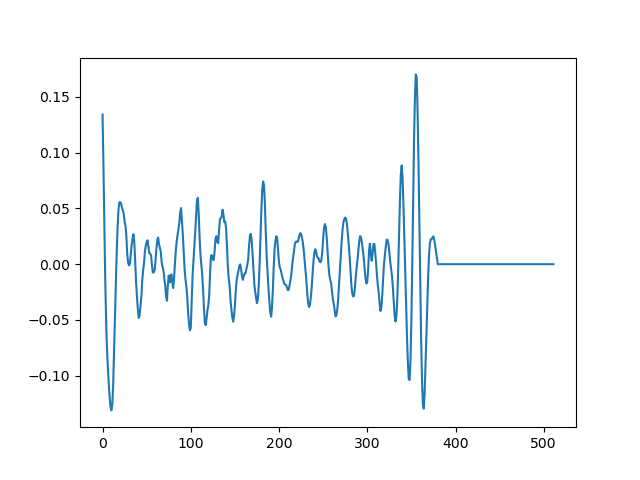

In [6]:
samplerate, audio_in = wavfile.read(f'{filenames[123]}.wav')
audio_in = audio_in / max(abs(audio_in))

audio_in = np.expand_dims(audio_in, -1)
audio_out = get_windowed_signal(audio_in, samplerate, N=512, noverlap=256, 
                                padding_value=2)

%matplotlib notebook
plt.plot(audio_out[-1])
plt.show()

### Testeo: `get_windows_and_labels`

In [7]:
homomorphic_dict = {'cutoff_freq': 10, 'delta_band': 5}
simplicity_dict = {'N': 64, 'noverlap': 32, 'm': 10, 'tau': 1}
vfd_dict = {'N': 64, 'noverlap': 32, 'kmin': 2, 'kmax': 2, 'step_size_method': 'unit'}
wavelet_dict = {'wavelet': 'db4', 'levels': [2,3,4], 'start_level': 1, 'end_level': 6}
spec_track_dict = {'freq_obj': [100, 120], 'N': 128, 'noverlap': 100, 'padding': 0, 
                   'repeat': 0, 'window': 'hann'}
samplerate, audio_in = wavfile.read(f'{filenames[184]}.wav')
audio_in = audio_in / max(abs(audio_in))

audio_bp = bandpass_filter(audio_in, samplerate, freq_stop_1=30, freq_pass_1=50, 
                           freq_pass_2=300, freq_stop_2=320, bp_method='scipy_fir')

%matplotlib notebook
#f = np.linspace(0, samplerate, len(audio_in))
#plt.plot(f, abs(np.fft.fft(audio_in)))
#plt.plot(f, abs(np.fft.fft(audio_bp)))
#plt.plot(audio_in)
#plt.plot(audio_bp)
#plt.show()

In [8]:
envelopes = get_envelope_pack(audio_bp, samplerate, homomorphic_dict, simplicity_dict, vfd_dict,
                              wavelet_dict, spec_track_dict)

print(envelopes.shape)

# %matplotlib notebook
# plt.plot(audio_bp)
# plt.plot(envelopes[:, 7])
# plt.show()

(19500, 8)


(2104, 64, 7)
(2104, 1)
(2104, 1)


<IPython.core.display.Javascript object>


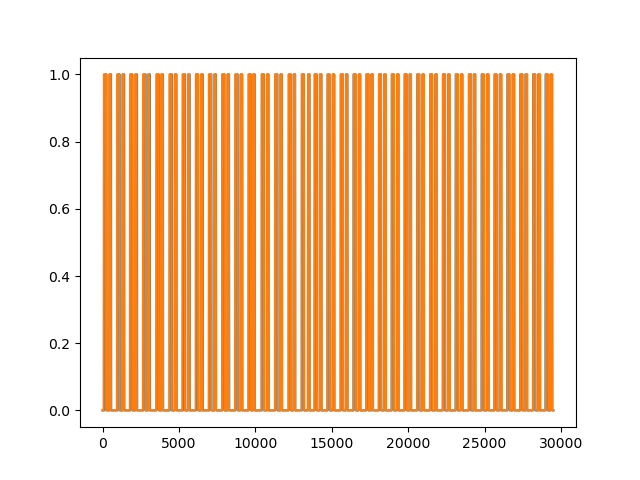

In [79]:
homomorphic_dict = {'cutoff_freq': 10, 'delta_band': 5}
simplicity_dict = {'N': 64, 'noverlap': 32, 'm': 10, 'tau': 1}
vfd_dict = {'N': 64, 'noverlap': 32, 'kmin': 2, 'kmax': 2, 'step_size_method': 'unit'}
wavelet_dict = {'wavelet': 'db4', 'levels': [2,3,4], 'start_level': 1, 'end_level': 5}
spec_track_dict = {'freq_obj': [100, 120], 'N': 128, 'noverlap': 100, 'padding': 0, 
                   'repeat': 0, 'window': 'hann'}
bp_parameters = [20, 30, 300, 320]

a, b, c = get_windows_and_labels(filenames[0], N=64, noverlap=50, activation_percentage=0.4,
                                 apply_bpfilter=True, bp_parameters=bp_parameters, append_audio=True, 
                                 append_envelopes=True, homomorphic_dict=homomorphic_dict, 
                                 simplicity_dict=simplicity_dict, vfd_dict=vfd_dict, 
                                 wavelet_dict=wavelet_dict, spec_track_dict=spec_track_dict)

print(a.shape)
print(b.shape)
print(c.shape)

# Definición de las etiquetas a considerar
s1_labels_list = list()
s2_labels_list = list()

# Obtención de los datos del archivo .mat
data_info = loadmat(f'{filenames[0]}.mat')

# Etiquetas a 50 Hz de samplerate
labels = data_info['PCG_states']

# Pasando a 1000 Hz
labels_adj = np.repeat(labels, 20)

# Agregando a la lista
s1_labels_list = (labels_adj == 1)
s2_labels_list = (labels_adj == 3)

%matplotlib notebook
plt.plot(s1_labels_list + s2_labels_list)
plt.plot(np.linspace(0, len(s1_labels_list), len(b)), b + c)
plt.show()

### Testeo: `get_heartsound_database`

1. Concatenar

In [34]:
# Concatenar bases
a1,b1,c1 = get_windows_and_labels(filenames[0], N=64, noverlap=int(0.8*64), activation_percentage=0.4)
a2,b2,c2 = get_windows_and_labels(filenames[1], N=64, noverlap=int(0.8*64), activation_percentage=0.4)

print(a1.shape)
print(a2.shape)

conc = np.zeros((0, 64, 1))

conc = np.concatenate((conc, a1), axis=0)
conc = np.concatenate((conc, a2), axis=0)

print(conc.shape)

(2266, 64, 1)
(2266, 64, 1)
(4532, 64, 1)


# Obteniendo la base de datos

In [95]:
homomorphic_dict = {'cutoff_freq': 10, 'delta_band': 5}
simplicity_dict = {'N': 64, 'noverlap': 32, 'm': 10, 'tau': 1}
vfd_dict = {'N': 64, 'noverlap': 32, 'kmin': 2, 'kmax': 2, 'step_size_method': 'unit'}
wavelet_dict = {'wavelet': 'db4', 'levels': [2,3,4], 'start_level': 1, 'end_level': 5}
spec_track_dict = {'freq_obj': [100, 120], 'N': 128, 'noverlap': 100, 'padding': 0, 
                   'repeat': 0, 'window': 'hann'}
bp_parameters = [20, 30, 300, 320]

# Definición de parámetros
homomorphic_dict = None
simplicity_dict = None
vfd_dict = None
wavelet_dict = None
spec_track_dict = None
hilbert_bool = False
append_envelopes = False


audio_db, s1_labels, s2_labels = \
                            get_heartsound_database(db_folder, ind_beg=0, ind_end=None, N=128, noverlap=128-16, 
                                                    padding_value=2, activation_percentage=0.5, 
                                                    append_audio=True, append_envelopes=append_envelopes, 
                                                    apply_bpfilter=True, bp_parameters=bp_parameters, 
                                                    homomorphic_dict=homomorphic_dict, hilbert_bool=hilbert_bool,
                                                    simplicity_dict=simplicity_dict, 
                                                    vfd_dict=vfd_dict, wavelet_dict=wavelet_dict, 
                                                    spec_track_dict=spec_track_dict)
print(audio_db.shape)
print(s1_labels.shape)
print(s2_labels.shape)

(618371, 128, 1)
(618371, 1)
(618371, 1)


# Dividiendo en Train y Test

In [101]:
labels = np.concatenate((s1_labels, s2_labels), axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(audio_db, labels, test_size=0.2)
print(labels.shape)

(618371, 2)


In [106]:
print(X_train.shape)
print(Y_train[:,0].shape)

(494696, 128, 1)
(494696,)


In [91]:
# save_database(db_folder, 'Database', N=128, noverlap=128-16, padding_value=2, 
#               activation_percentage=0.5, ind_beg=0, ind_end=None, 
#               apply_bpfilter=True, bp_parameters=bp_parameters, 
#               append_audio=True, append_envelopes=False, 
#               homomorphic_dict=homomorphic_dict,
#               hilbert_bool=True,
#               simplicity_dict=simplicity_dict, 
#               vfd_dict=vfd_dict, wavelet_dict=wavelet_dict, 
#               spec_track_dict=spec_track_dict)

# Expresando nuestra matriz como tensor 

In [112]:
# Y transformando a tensor
X_train_tens = tf.convert_to_tensor(X_train, dtype='float32')
s1_train_tens = tf.convert_to_tensor(Y_train[:,0], dtype='float32')
s2_train_tens = tf.convert_to_tensor(Y_train[:,1], dtype='float32')

X_test_tens = tf.convert_to_tensor(X_test, dtype='float32')
s1_test_tens = tf.convert_to_tensor(Y_test[:,0], dtype='float32')
s2_test_tens = tf.convert_to_tensor(Y_test[:,1], dtype='float32')


# Print
display(X_train_tens.shape)
display(s1_train_tens.shape)
display(X_test_tens.shape)
display(s1_test_tens.shape)

TensorShape([494696, 128, 1])

TensorShape([494696])

TensorShape([123675, 128, 1])

TensorShape([123675])

# Definición de las capas de la red neuronal

In [110]:
# Definición de la entrada
x_in = tf.keras.Input(shape=(128, 1), dtype='float32')

# Definición de la capa de máscara
x_masked = tf.keras.layers.Masking(mask_value=2, input_shape=(128, 1))(x_in)

# Definición de las capas convolucionales
x_conv1 = tf.keras.layers.Conv1D(filters=5, kernel_size=200, padding='same', activation='relu', 
                                 kernel_initializer='glorot_uniform')(x_masked)
x_conv2 = tf.keras.layers.Conv1D(filters=10, kernel_size=200, padding='same', activation='relu', 
                                 kernel_initializer='glorot_uniform')(x_conv1)
x_conv3 = tf.keras.layers.Conv1D(filters=20, kernel_size=100, padding='same', activation='relu', 
                                 kernel_initializer='glorot_uniform')(x_conv2)
x_conv4 = tf.keras.layers.Conv1D(filters=20, kernel_size=100, padding='same', activation='relu', 
                                 kernel_initializer='glorot_uniform')(x_conv3)

# Definición de la capa flatten
x_flat = tf.keras.layers.Flatten()(x_conv4)

# Definición de las capas fully connected
x_full1 = tf.keras.layers.Dense(units=30, activation='relu')(x_flat)
x_full2 = tf.keras.layers.Dense(units=80, activation='relu')(x_full1)
x_full3 = tf.keras.layers.Dense(units=70, activation='relu')(x_full2)

# Definición de la última capa
x_out_s1 = tf.keras.layers.Dense(units=1, activation='sigmoid', 
                                 kernel_initializer='glorot_uniform')(x_full3)
x_out_s2 = tf.keras.layers.Dense(units=1, activation='sigmoid', 
                                 kernel_initializer='glorot_uniform')(x_full3)

# Definición del modelo
model = tf.keras.Model(inputs=x_in, outputs=[x_out_s1, x_out_s2], name='Test_model_1')

# Compilando las opciones del modelo
model.compile(optimizer='Adam', loss=['binary_crossentropy', 'binary_crossentropy'], 
              metrics=['accuracy'], loss_weights=[1., 1.])

# Mostrando el resumen
model.summary()

Model: "Test_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 128, 1)       0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 128, 5)       1005        masking_1[0][0]                  
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 128, 10)      10010       conv1d_4[0][0]                   
_______________________________________________________________________________________

# Entrenando

In [111]:
# Ajustando el modelo
tf.debugging.set_log_device_placement(True)
history = model.fit(x=X_train, y=[s1_train_tens, s2_train_tens], epochs=10, batch_size=70, verbose=1)

Epoch 1/10
7068/7068 [==============================] - 70s 10ms/step - loss: 0.4766 - dense_8_loss: 0.2573 - dense_9_loss: 0.2193 - dense_8_accuracy: 0.8911 - dense_9_accuracy: 0.9102
Epoch 2/10
7068/7068 [==============================] - 70s 10ms/step - loss: 0.4161 - dense_8_loss: 0.2294 - dense_9_loss: 0.1867 - dense_8_accuracy: 0.9063 - dense_9_accuracy: 0.9255
Epoch 3/10
7068/7068 [==============================] - 71s 10ms/step - loss: 0.3995 - dense_8_loss: 0.2217 - dense_9_loss: 0.1778 - dense_8_accuracy: 0.9096 - dense_9_accuracy: 0.9293 5s - loss: 0.4001 -
Epoch 4/10
7068/7068 [==============================] - 70s 10ms/step - loss: 0.3876 - dense_8_loss: 0.2167 - dense_9_loss: 0.1708 - dense_8_accuracy: 0.9114 - dense_9_accuracy: 0.9319
Epoch 5/10
7068/7068 [==============================] - 70s 10ms/step - loss: 0.3784 - dense_8_loss: 0.2125 - dense_9_loss: 0.1659 - dense_8_accuracy: 0.9137 - dense_9_accuracy: 0.9345
Epoch 6/10
7068/7068 [==============================] -

# Y evaluando

In [117]:
loss_tot, loss_s1, loss_s2, acc_s1, acc_s2 = model.evaluate(x=X_test, y=[s1_test_tens, s2_test_tens], verbose=1)

3865/3865 [==============================] - 13s 3ms/step - loss: 0.3565 - dense_8_loss: 0.2025 - dense_9_loss: 0.1541 - dense_8_accuracy: 0.9181 - dense_9_accuracy: 0.9390


In [118]:
print('Loss: ', loss_tot)
print('Test Accuracy S1: ', acc_s1 * 100, '%')
print('Test Accuracy S2: ', acc_s2 * 100, '%')

Loss:  0.3565424382686615
Test Accuracy S1:  91.8148398399353 %
Test Accuracy S2:  93.89852285385132 %


# Guardando

In [120]:
model.save('Models/Model_1.h5')

In [567]:
audio_1, s1_1, s2_1 = get_windows_and_labels(filenames[0], N=128, noverlap=128-16, activation_percentage=0.4)

# Finalmente realizando la predicción
y_pred = model.predict(audio_1)

%matplotlib notebook
plt.figure(figsize=(10,4))
lim = 600
plt.subplot(2,1,1)
plt.plot(y_pred[0], label='Pred')
plt.plot(s1_1, label='Truth')
plt.xlim([0, lim])
plt.legend(loc='upper right')
plt.ylabel('S1')

plt.subplot(2,1,2)
plt.plot(y_pred[1], label='Pred')
plt.plot(s2_1, label='Truth')
plt.xlim([0, lim])
plt.legend(loc='upper right')
plt.xlabel('Tiempo [muestras]')
plt.ylabel('S2')

plt.suptitle('Predicciones vs Ground Truth')
plt.show()

ValueError: in user code:

    c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer conv1d_12 is incompatible with the layer: expected axis -1 of input shape to have value 9 but received input with shape [None, 128, 1]


In [119]:
audio_db[4].shape

(128, 1)

# Multiples entradas

In [576]:
# Definición de la entrada
x_in = tf.keras.Input(shape=(128, 9), dtype='float32')

# Definición de la capa de máscara
x_masked = tf.keras.layers.Masking(mask_value=2, input_shape=(128, 9))(x_in)

# Definición de las capas convolucionales
x_conv1 = tf.keras.layers.Conv1D(filters=5, kernel_size=200, padding='same', activation='relu', 
                                 kernel_initializer='glorot_uniform')(x_masked)
x_conv2 = tf.keras.layers.Conv1D(filters=10, kernel_size=200, padding='same', activation='relu', 
                                 kernel_initializer='glorot_uniform')(x_conv1)
x_conv3 = tf.keras.layers.Conv1D(filters=20, kernel_size=100, padding='same', activation='relu', 
                                 kernel_initializer='glorot_uniform')(x_conv2)
x_conv4 = tf.keras.layers.Conv1D(filters=20, kernel_size=100, padding='same', activation='relu', 
                                 kernel_initializer='glorot_uniform')(x_conv3)

# Definición de la capa flatten
x_flat = tf.keras.layers.Flatten()(x_conv4)

# Definición de las capas fully connected
x_full1 = tf.keras.layers.Dense(units=30, activation='relu')(x_flat)
x_full2 = tf.keras.layers.Dense(units=80, activation='relu')(x_full1)
x_full3 = tf.keras.layers.Dense(units=70, activation='relu')(x_full2)

# Definición de la última capa
x_out_s1 = tf.keras.layers.Dense(units=1, activation='sigmoid', 
                                 kernel_initializer='glorot_uniform')(x_full3)
x_out_s2 = tf.keras.layers.Dense(units=1, activation='sigmoid', 
                                 kernel_initializer='glorot_uniform')(x_full3)

# Definición del modelo
model = tf.keras.Model(inputs=x_in, outputs=[x_out_s1, x_out_s2], name='Test_model_1')

# Compilando las opciones del modelo
model.compile(optimizer='Adam', loss=['binary_crossentropy', 'binary_crossentropy'], 
              metrics=['accuracy'], loss_weights=[1., 1.])

# Mostrando el resumen
model.summary()

Model: "Test_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
masking_5 (Masking)             (None, 128, 9)       0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 128, 5)       9005        masking_5[0][0]                  
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 128, 10)      10010       conv1d_20[0][0]                  
_______________________________________________________________________________________

In [577]:
# Ajustando el modelo
tf.debugging.set_log_device_placement(True)
model.fit(x=audio_db_tens, y=[s1_labels_tens, s2_labels_tens], batch_size=70, epochs=10, verbose=1)

Epoch 1/10
659/659 [==============================] - 5s 7ms/step - loss: 0.4543 - dense_28_loss: 0.2218 - dense_29_loss: 0.2325 - dense_28_accuracy: 0.9059 - dense_29_accuracy: 0.9048
Epoch 2/10
659/659 [==============================] - 5s 7ms/step - loss: 0.3150 - dense_28_loss: 0.1568 - dense_29_loss: 0.1582 - dense_28_accuracy: 0.9410 - dense_29_accuracy: 0.9360
Epoch 3/10
659/659 [==============================] - 5s 7ms/step - loss: 0.2929 - dense_28_loss: 0.1498 - dense_29_loss: 0.1431 - dense_28_accuracy: 0.9419 - dense_29_accuracy: 0.9434
Epoch 4/10
659/659 [==============================] - 6s 8ms/step - loss: 0.2740 - dense_28_loss: 0.1387 - dense_29_loss: 0.1353 - dense_28_accuracy: 0.9453 - dense_29_accuracy: 0.9461
Epoch 5/10
659/659 [==============================] - 5s 7ms/step - loss: 0.2674 - dense_28_loss: 0.1327 - dense_29_loss: 0.1347 - dense_28_accuracy: 0.9472 - dense_29_accuracy: 0.9472
Epoch 6/10
659/659 [==============================] - 5s 7ms/step - loss: 0

(1837, 128, 9)


<IPython.core.display.Javascript object>


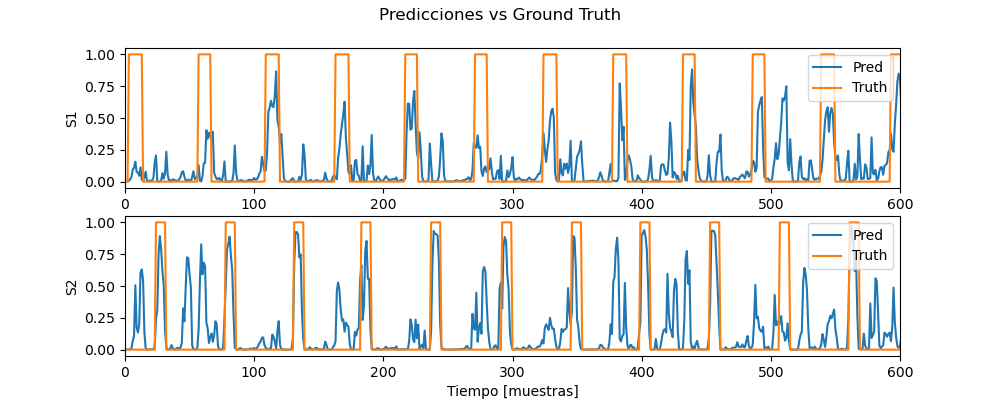

In [578]:
homomorphic_dict = {'cutoff_freq': 10, 'delta_band': 5}
simplicity_dict = {'N': 64, 'noverlap': 32, 'm': 10, 'tau': 1}
vfd_dict = {'N': 64, 'noverlap': 32, 'kmin': 2, 'kmax': 2, 'step_size_method': 'unit'}
wavelet_dict = {'wavelet': 'db4', 'levels': [2,3,4], 'start_level': 1, 'end_level': 5}
spec_track_dict = {'freq_obj': [100, 120], 'N': 128, 'noverlap': 100, 'padding': 0, 
                   'repeat': 0, 'window': 'hann'}
bp_parameters = [20, 30, 300, 320]

audio_1, s1_1, s2_1 = get_windows_and_labels(filenames[0], N=128, noverlap=128-16, activation_percentage=0.4,
                                 apply_bpfilter=True, bp_parameters=bp_parameters, append_audio=True, 
                                 append_envelopes=True, homomorphic_dict=homomorphic_dict, 
                                 simplicity_dict=simplicity_dict, vfd_dict=vfd_dict, 
                                 wavelet_dict=wavelet_dict, spec_track_dict=spec_track_dict)

print(audio_1.shape)

# Finalmente realizando la predicción
y_pred = model.predict(audio_1)

%matplotlib notebook
plt.figure(figsize=(10,4))
lim = 600
plt.subplot(2,1,1)
plt.plot(y_pred[0], label='Pred')
plt.plot(s1_1, label='Truth')
plt.xlim([0, lim])
plt.legend(loc='upper right')
plt.ylabel('S1')

plt.subplot(2,1,2)
plt.plot(y_pred[1], label='Pred')
plt.plot(s2_1, label='Truth')
plt.xlim([0, lim])
plt.legend(loc='upper right')
plt.xlabel('Tiempo [muestras]')
plt.ylabel('S2')

plt.suptitle('Predicciones vs Ground Truth')
plt.show()